# 🕒Time Series Course: A Practical Guide😎

<img src="https://user-images.githubusercontent.com/115424463/277927582-105276ff-72a9-439d-b80e-e44a33ba5c5d.jpg" alt="'Time Series in Dali style' by AI">

### Picture: Time Series in Dali style

**Hello, fellow 'getting started' data fan 🤓!** 

Just like you, I've been steadily advancing through the micro-courses, one by one, until I reached [**Time Series**](https://www.kaggle.com/learn/time-series). While it offers a wealth of essential theory, its 'micro' nature apperently restricts the capacity for practical demostractions. Therefore, I thought there might be public interest for a practical guide.

What you **Will Find** in the project:
- All Time Series analysis methods covered in the course. I introduce them one by one with visualizations, code comments, and pipelines that take you from raw data to submission.csv. for [*Store Sales - Time Series Forecasting*](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) competion.

- Interactive visualizations. You can select a product, a store, and dates in the `Data display parameters` to make all plots adjust to your choices.  To utilize this feature, you should 'fork' (copy) the notebook and run the relevant sections.

- **10 serialized models**. When you fork the notebook, you won't need to train them anew. Simply apply the pre-trained models for predictions and visualization according to your preferences.

- All the utilities from the course (Periodogram, Autocorrelation, Widgets, etc). I've organized them conveniently by section so you can easily copy and take them away.

- Some reflections on theoretical issues. It would be great to discuss them in comments. 

What You **Won't Find** in This Notebook:
- Any groundbreaking decisions on achieving a high score (come on, it's 'getting started'). 
- Libraries and data are within the scope of the course.
- I also regret passing a high score CSV through the code in one of the versions. At the time, it seemed like an innocent promotional idea, and I only read [Kaggle Community Guidlines](https://www.kaggle.com/community-guidelines) after doing that. So, it's also part of the 'getting started' process: I've learned some good manners. 

*Enjoy the ride!* <br>
<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
<strong> Please upvote if you find this valuable, and don't hesitate to leave comments if you have any feedback or suggestions </strong> <br> 
    </blockquote>

# SETTINGS

 ## imports

In [1]:
%%capture
!pip install pandas==1.4.2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from warnings import simplefilter
simplefilter("ignore")

## load data
- **train.csv** The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- *store_nbr* identifies the store at which the products are sold.
- *family* identifies the type of product sold.
- *sales* gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips). 
- *onpromotion* gives the total number of items in a product family that were being promoted at a store at a given date.


- **test.csv**  The test data, having the same features as the training data. You will predict the target sales for the dates in this file. The dates in the test data are for the 15 days after the last date in the training data.

- **holidays_events.csv**  Holidays and Events, with metadata. NOTE: Pay special attention to the `transferred` column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

- **Additional Notes**  Wages in the public sector are paid `every two weeks` on the 15 th and on the last day of the month. Supermarket sales could be affected by this. A magnitude `7.8 earthquake` struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [3]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

train = pd.read_csv(comp_dir / 'train.csv',                            
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32'
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
train['date'] = train.date.dt.to_period('D')

train = (train
       .set_index(['date', 'family', 'store_nbr'])         # Setting MultiIndex to make unique identifiers for each 'sales' item
       .sort_index()
      )

In [4]:
test = pd.read_csv(comp_dir/'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'family', 'store_nbr']).sort_index()

In [5]:
holidays_events = pd.read_csv(
    comp_dir/ "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

## Visualization Settings

In [6]:
# matplotlib defaults
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="#556B2F",          
    style=".-",               
    markeredgecolor="#4169E1", 
    markerfacecolor="#8B0000", 
    legend=False              
)

%config InlineBackend.figure_format = 'retina'

### Data display parameters

<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:0px;">
<strong> Here is where you can pick what the rest of the notebook will be showing you </strong></blockquote>

In [7]:
STORE  = '1'
FAMILY = 'BREAD/BAKERY'
START = '2016-01-01'
END = '2016-06-15'

print (
    f'Number of stores:\033[1m{train.index.get_level_values("store_nbr").nunique()}\033[0m \n\n'
    f'Time range in the training set: from \033[1m{train.index.get_level_values("date")[0]}\033[0m till \033[1m{train.index.get_level_values("date")[-1]}\033[0m \n\n'
    f'FAMILY options:{train.index.get_level_values("family").unique().astype("str")}'
)

Number of stores:54 

Time range in the training set: from 2013-01-01 till 2017-08-15 

FAMILY options:Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object', name='family')


In [8]:
# main function for visualization
def check (X, 
           y = train,
           START = START, 
           END = END,
           FAMILY = FAMILY,
           STORE = None,
           Prefix = None,
           model = None,
           FIT = True):
    
    if y is train:
        y =  (train
              .groupby(['family', 'date'])                  # it calculates an averaged value across all the stores
              .mean()                                       # merely for the sake of simplicity 
              .query ('family == @FAMILY')                    
              .reset_index(level = 'family')
              .rename(columns={'sales':'ground_truth_average'})
              .loc [START:END, 'ground_truth_average']
              )
    else:
        y = (y
             .stack([0,1])
             .to_frame()
             .query('family == @FAMILY and store_nbr == @STORE')
             .reset_index(['family', 'store_nbr'],drop=True)
             .rename(columns={0:'ground_truth'})
             .loc[START:END]
             .squeeze()
            )
   
    if STORE:
        X = (X
             .query('family == @FAMILY and store_nbr == @STORE')
             .reset_index(['family', 'store_nbr'],drop=True)
           )
       
    X_check = X.loc[START:END,:]
    
    if model:
        model_ = model    
    else:
        model_ = LinearRegression (fit_intercept=False)
        
    if FIT:
        model_.fit(X_check, y)
        y_fit = pd.Series(model_.predict(X_check), index=X_check.index, name = 'y_fit').clip(0.0)
    else:
        y_fit =  X_check.squeeze()
            
    rmsle_train = mean_squared_log_error(y, y_fit) ** 0.5

    print(f'Mean Squared Log Error: \033[1m{rmsle_train:.5f}\033[0m')
        
    ax = y.plot(**plot_params, alpha=0.5)
    y_fit.plot(ax=ax, color="#4B0082")
    
    if Prefix:
        ax.set_title (f'{Prefix} for {FAMILY} at store {STORE} from {START} till {END}')
    else:
        ax.set_title (f'Average sales of {FAMILY} from {START} till {END}')
    ax.legend();

## Data sets for training and visualization

In [9]:
X_train = train.copy()

y_train = (X_train
           .unstack(['family', 'store_nbr'])
           .loc[:,"sales"]
          )

# Simple index with dates
index_ = X_train.index.get_level_values('date').unique() 


# Ground truth Series for the filtered data 
y_true = (y_train
         .stack(['family', 'store_nbr'])
         .to_frame()
         .query('family == @FAMILY and store_nbr == @STORE')
         .reset_index(['family', 'store_nbr'],drop=True)
         .rename(columns={0:'ground_truth'})
         .loc[START:END,:]
         .squeeze()
                )

# *A theoretical issue*: **MultiIndex**
I believe this is the starting point of practical application of the theory.

In time series, we analyze temporal dependencies. We compare the state of the Target variable with itself at a different point in time. This implies a couple of things:

- Each unit of the target should be a time-indexed series containing a slice of information about the state of all objects at that moment. Thus, in each column, we will have a time-varying value of the same object. In other words, frozen pizza and bicycles will be in separate (independent) columns, and each of these columns will contain a time series of changes in the studied parameter (price, units sold, etc.).

- To ensure that pizza stays with pizza and bikes with bikes, the data needs to be grouped by all categorical features in the dataset and spread out into a 'wide' series. Then this series is taken at each new moment, and the DataFrame is configured line by line. This is our `y`

This is where a MultiIndex comes in handy.

1. You add all your categorical features to the index and make it a MultiIndex:  
`.set_index(['date', 'family', 'store_nbr']`. <br>
*Now, your index has 3 columns, and your TARGET is 1 value per row.*

2. You pivot all index levels but 'date' from columns (long format) to rows (wide format). Note that it's still the same MultiIndex!
`unstack(['family', 'store_nbr'])` <br>
*Now, your index has 1 column 'date' and 2 rows and your TARGET is **1782** values per row* 

Why is this helpful? Because now we have a standard **'dates'** column, just like any other time series. <br>
When you query `.loc['2017-01-01']`, you obtain an array of 1782 values, the result of 54 commodity families being sold in 33 stores, each uniquely indexed.

And what's in the columns? Precisely! Time-dependent changes for each of the 1782 values.<br> 
So, the Linear Regression model interprets 1782 separate vectors, which essentially means that we have 1782 different Linear Regression models in one.

# BASELINE SUBMISSION (TREND)
- Public Score (RMSLE): **0.59435**

In [10]:
"""
We initiate X_time matrix with 2 columns: 
- the "1" for the regression to count the y-intercept when ajusting weight for this "1"
- a time-dummy to work for detrending
"""

from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index = index_,
    constant = True,                # for y-intercept
    order = 1,                      # time-dummy (to capture the trend)
    drop = True,                  
)

X_time = dp.in_sample()             # 'in_sample' means along the given index (the dates in our training set)

#Check
X_time.shape, X_time.isna().sum().sum()

((1684, 2), 0)

Mean Squared Log Error: 0.32976


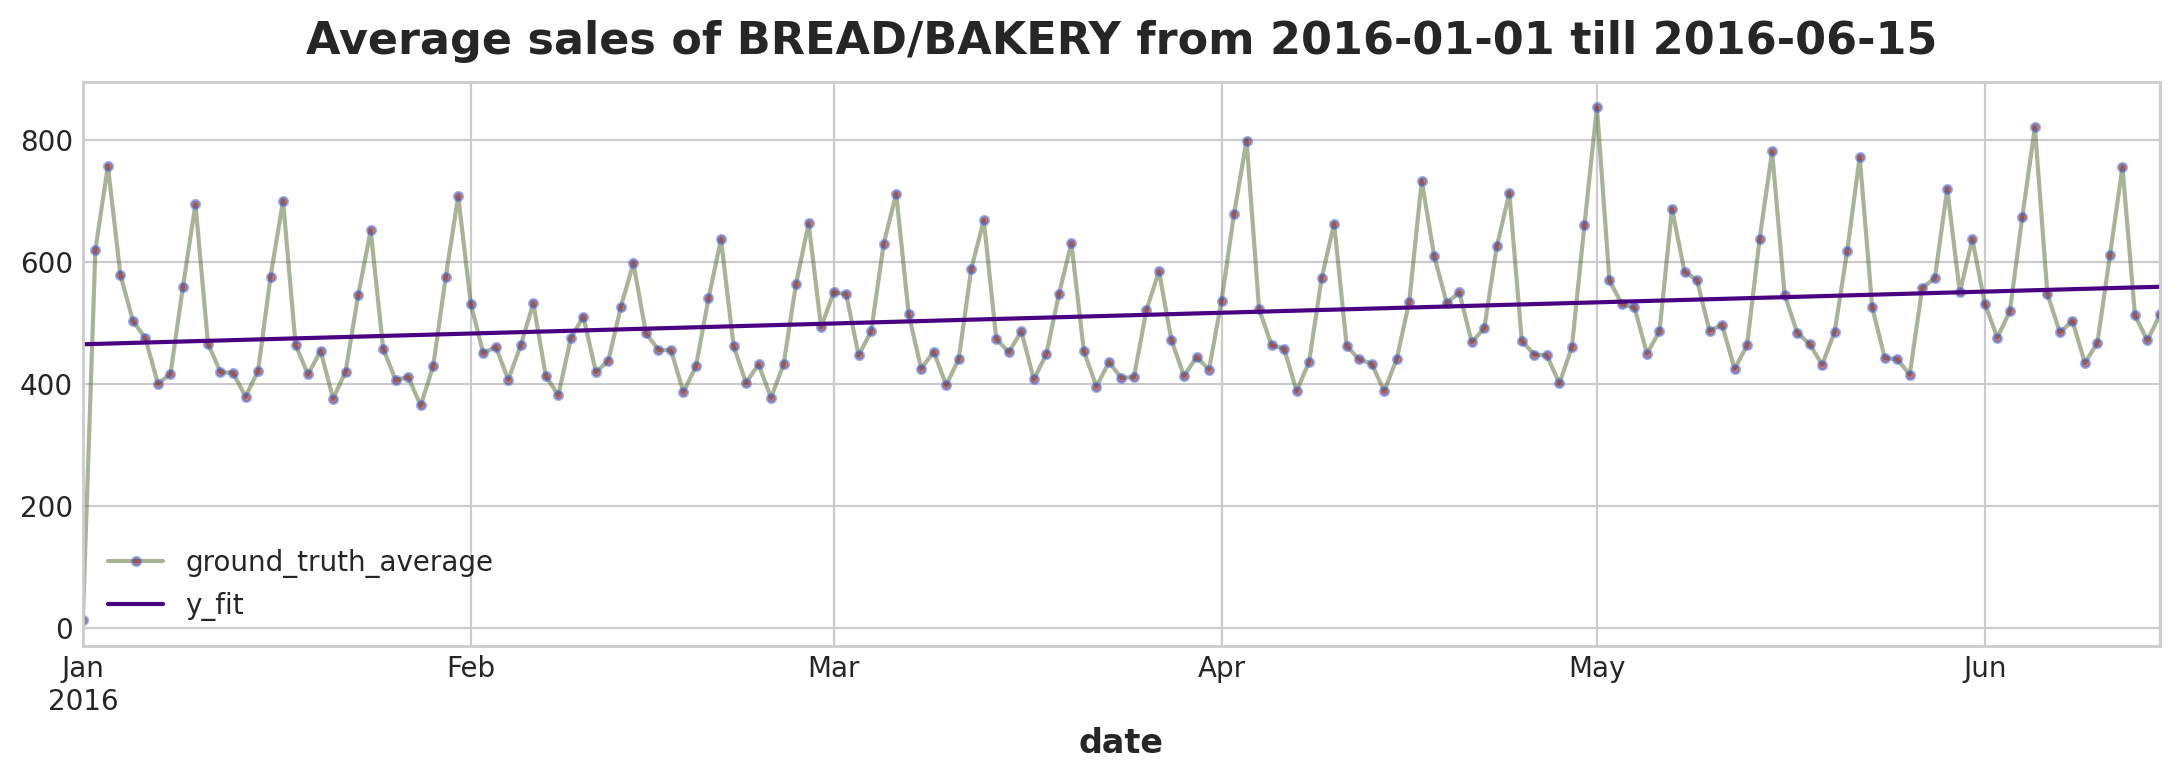

In [11]:
"""
Visualizing fitted curves against average sales (rather than per-family AND per-store) 
in this section is mainly to save trouble replicating the time_dummy across the MultiIndex levels.
"""
check(X_time)

In [12]:
"""
y_train has a 'wide' format and the model learns to predict not just 1 value, but 1782 at once.
"""
# base_model = LinearRegression (fit_intercept = False).fit(X_time, y_train)
# joblib.dump(base_model, 'baseline_model.pkl')

"\ny_train has a 'wide' format and the model learns to predict not just 1 value, but 1782 at once.\n"

In [13]:
# Create features for test set
X_time_test = dp.out_of_sample(steps=16)    # 'out_of_sample (16)' means along the next 16 time-index labels ('days' in our case)
X_time_test.index.name = 'date'

In [14]:
base_model = joblib.load('/kaggle/input/timeseriescourse-models/baseline_model.pkl')
y_submit = pd.DataFrame(base_model.predict(X_time_test),               
                        index = X_time_test.index,      
                        columns = y_train.columns).clip(0.0)

In [15]:
submission_0 = (y_submit
            .stack(['family', 'store_nbr'])
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_0.to_csv('/kaggle/working/submission.csv', index=False)

# *A theoretical issue*: **Polynomial Order**
**DeterministicProcess** serves as a useful tool for employing Linear Regression with a polynomial order, 
allowing you to introduce curvature to the linear curve.<br>
But the truth is that the curve with any order, greater than 1 *FREAKS OUT* beyond the training sample.<br>
Think of this: when you 'fit' a LinReg, you adjust weights to the terms of your polynomial and keep them 'in a leash'.<br> 
But when you 'predict', the weights remain the same, while the terms for the new time period grow in the specified order..<br>
Given this behavior, it's challenging for me to find practical use cases for polynomial orders other than "1."<br>
**please share your thoughts in the comments**

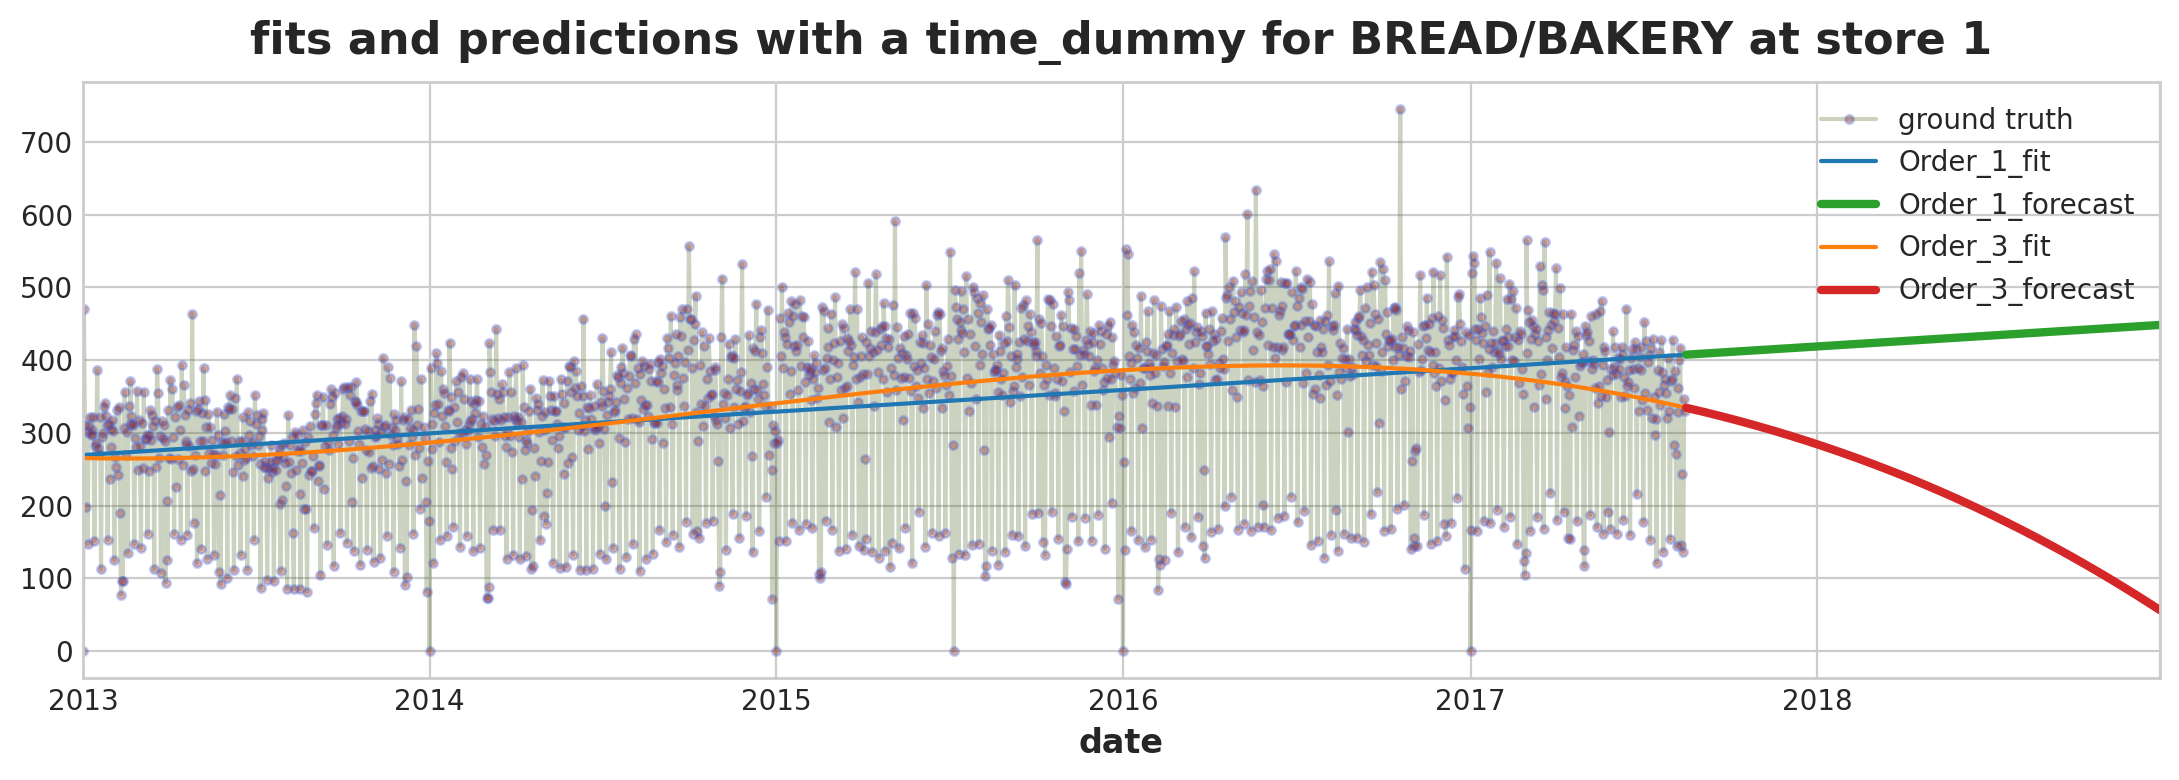

In [16]:
# try different ORDER values to see visualisation of my above statement
ORDER = 3

dp_2 = DeterministicProcess(index = index_,
                            constant = True, 
                            order = ORDER, 
                            drop = False)
X_time_1_test = dp.out_of_sample(steps=500)
X_time_n = dp_2.in_sample()
X_time_n_test = dp_2.out_of_sample(steps=500)
demo_model = LinearRegression (fit_intercept = False).fit(X_time_n, y_train)

y_order_1 = pd.DataFrame(base_model.predict(X_time),index = X_time.index,columns = y_train.columns)
y_order_1 = y_order_1.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_1_fore = pd.DataFrame(base_model.predict(X_time_1_test),index = X_time_1_test.index,columns = y_train.columns)
y_order_1_fore = y_order_1_fore.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_n = pd.DataFrame(demo_model.predict(X_time_n),index = X_time_n.index,columns = y_train.columns)
y_order_n = y_order_n.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_order_n_fore = pd.DataFrame(demo_model.predict(X_time_n_test),index = X_time_n_test.index,columns = y_train.columns)
y_order_n_fore = y_order_n_fore.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

y_fact = y_train.stack([0,1]).to_frame().query('family == @FAMILY and store_nbr == @STORE').reset_index(['family', 'store_nbr'],drop=True).squeeze()

ax = y_fact.plot (**plot_params, alpha = 0.3, label=f"ground truth")
ax = y_order_1.plot(ax=ax, label="Order_1_fit")
ax = y_order_1_fore.plot(ax=ax, label="Order_1_forecast", color="C2", linewidth = 3)
ax = y_order_n.plot(ax=ax, label=f"Order_{ORDER}_fit")
ax = y_order_n_fore.plot(ax=ax, label=f"Order_{ORDER}_forecast", color="C3", linewidth = 3)
ax.set_title (f'fits and predictions with a time_dummy for {FAMILY} at store {STORE}')
_ = ax.legend()

# SUBMISSION WITH SEASONS ACCOUNTED
- Public Score (RMSLE): **0.53266**

In [17]:
from scipy.signal import periodogram

def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Periodogram for BREAD/BAKERY at store 1 from 2016-01-01 till 2016-06-15


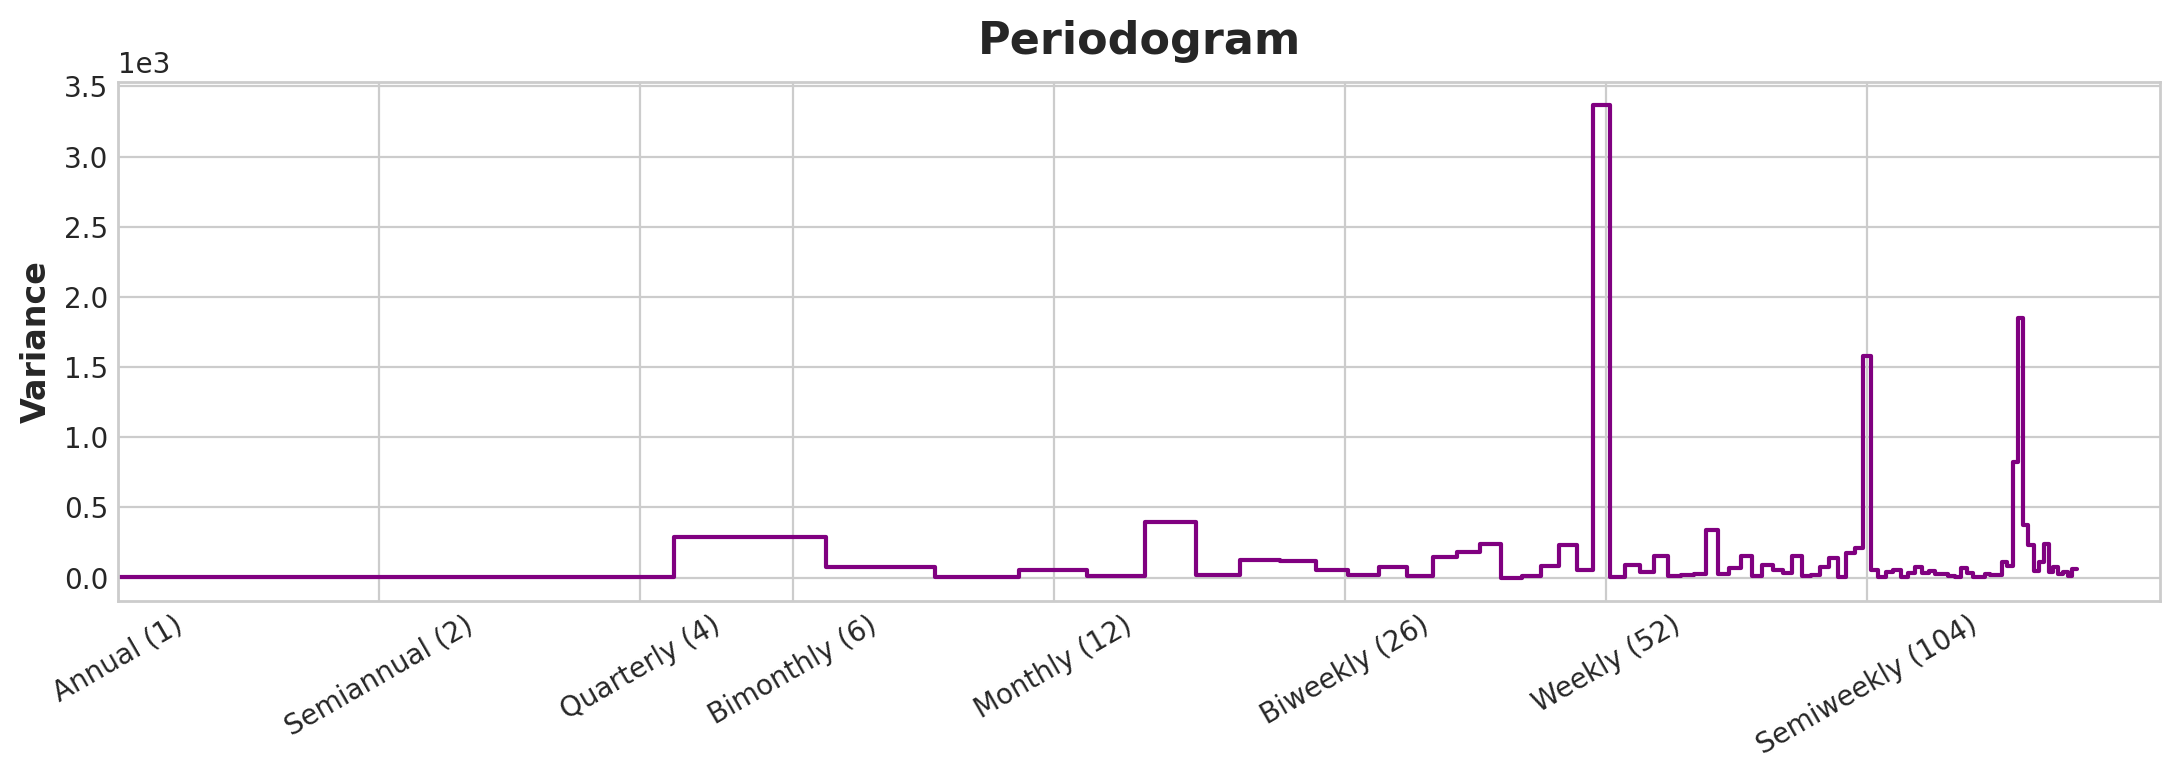

In [18]:
print (f'Periodogram for {FAMILY} at store {STORE} from {START} till {END}')
plot_periodogram(y_true);

## Capture Seasons with day_of_week

In [19]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq}) for {FAMILY} at store {STORE}from {START} till {END}")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

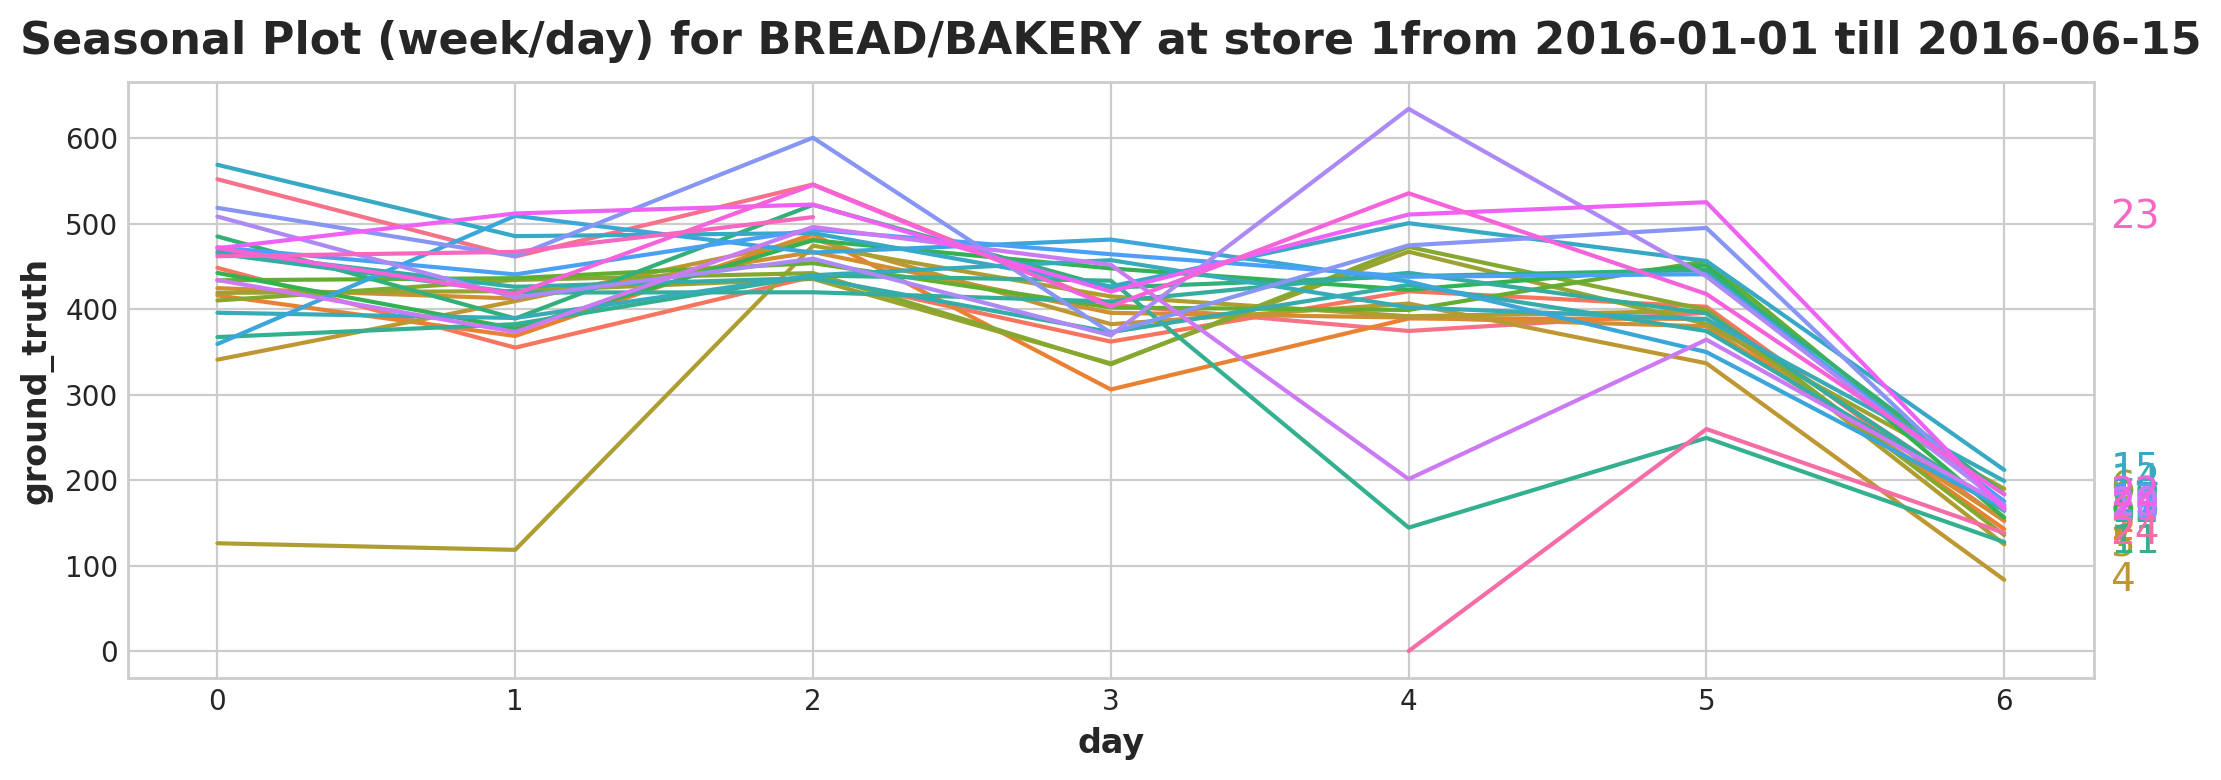

In [20]:
X = y_true.to_frame()
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
seasonal_plot(X, y="ground_truth", period="week", freq="day");

In [21]:
"""
Add OHE matrix for day of the week
"""
X_seasonal = dp.in_sample()

day_of_week = pd.Series(X_seasonal.index.dayofweek, index = index_)
X_day_of_week = pd.get_dummies(day_of_week, prefix = 'day_of_week')
X_seasonal = pd.concat([X_seasonal, X_day_of_week], axis=1)

# Check
X_seasonal.shape, X_seasonal.isna().sum().sum()

((1684, 9), 0)

Mean Squared Log Error: 0.27609


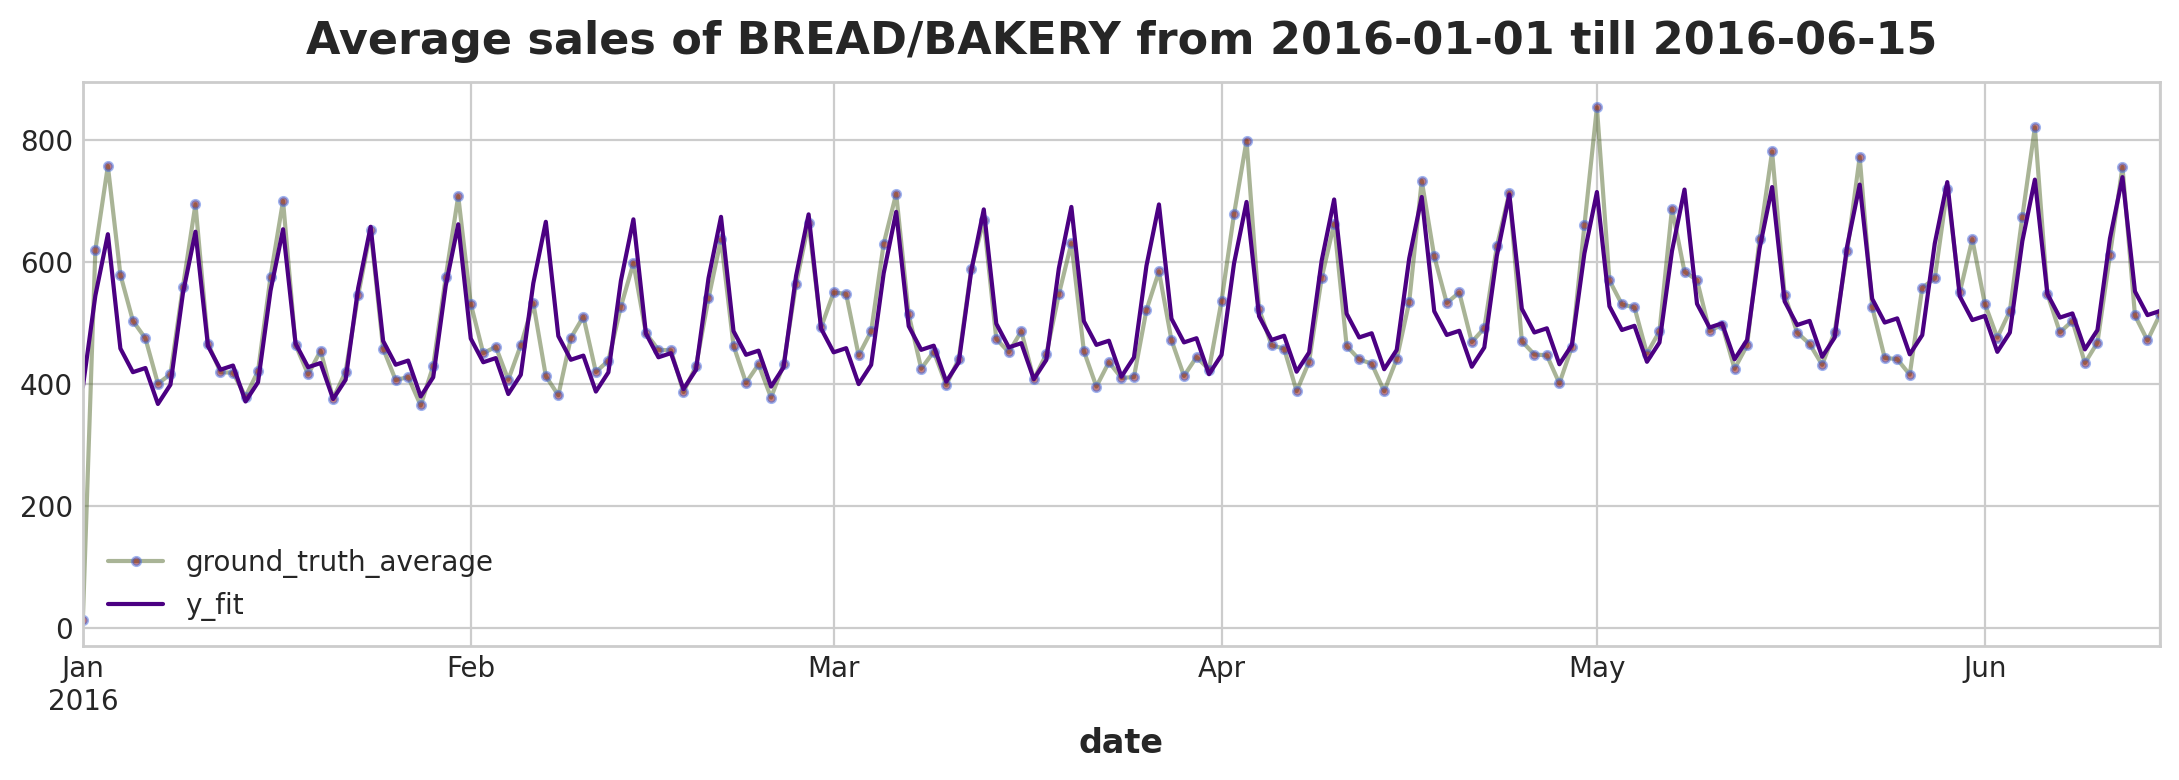

In [22]:
check(X_seasonal)

## Capture Seasons with Fourier

In [23]:
from statsmodels.tsa.deterministic import CalendarFourier

fourier = CalendarFourier(freq="A", order=10)            
dp_fourier = DeterministicProcess(
            index = index_,
            constant=False,             
            order=1,             
            seasonal=True,                                    
            additional_terms=[fourier],     
            drop=True
)
X_fourier = dp_fourier.in_sample()
X_seasonal = pd.concat ([X_seasonal, X_fourier], axis=1)

# Check
X_seasonal.shape, X_seasonal.isna().sum().sum()

((1684, 37), 0)

Mean Squared Log Error: 0.10720


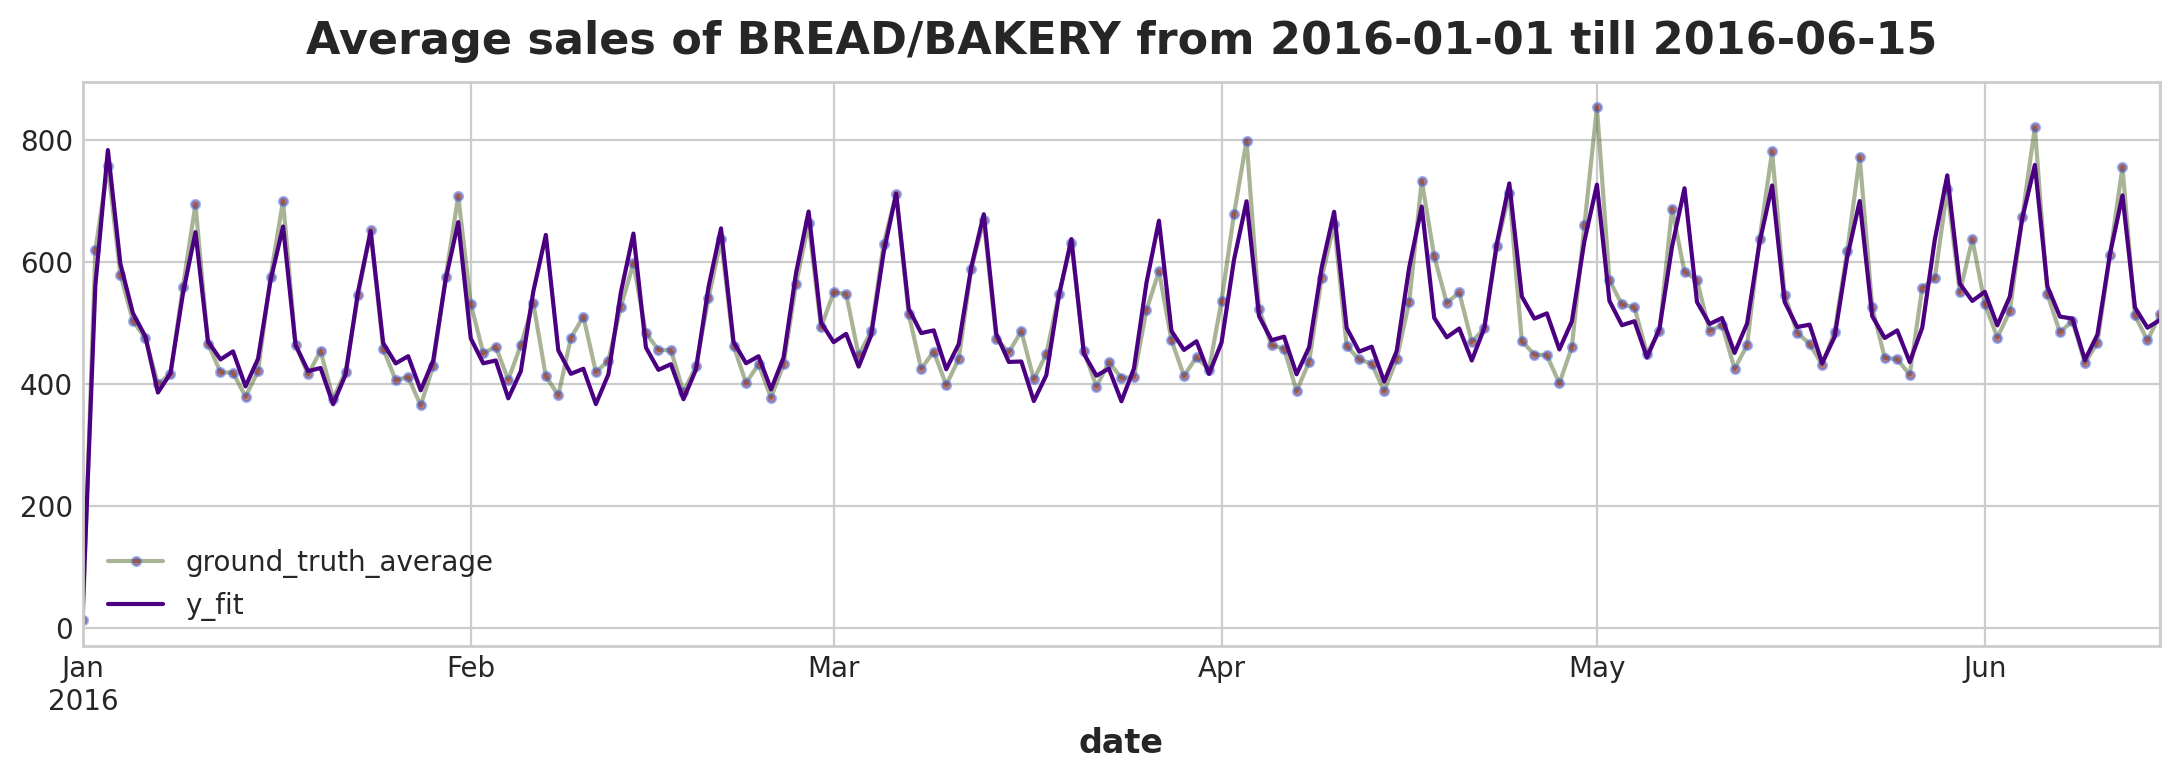

In [24]:
check(X_seasonal)

## Capture Seasons with holidays

*Pay special attention to the 'transferred' column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday.*

In [25]:
"""
NOTE: This feature covers New Year.
"""
holidays = (holidays_events  
            .query("transferred == False")                            # drop the transferred holidays, since they are regular days
            .query("locale == 'National'")                            # keep the National holidays only, since the location of the stores is unknown
            .loc[:,'description']                                     # keep one column with holidays names
            .to_frame().assign(description=lambda x: x.description.cat.remove_unused_categories())
           )
duplicated_dates = holidays.index.duplicated(keep='first')
holidays = holidays[~duplicated_dates]

X_holidays = pd.get_dummies (holidays)
X_seasonal = X_seasonal.join(X_holidays, on='date', how='left').fillna(0.0)   

# Check
X_seasonal.shape, X_seasonal.isna().sum().sum()

((1684, 109), 0)

Mean Squared Log Error: 0.06497


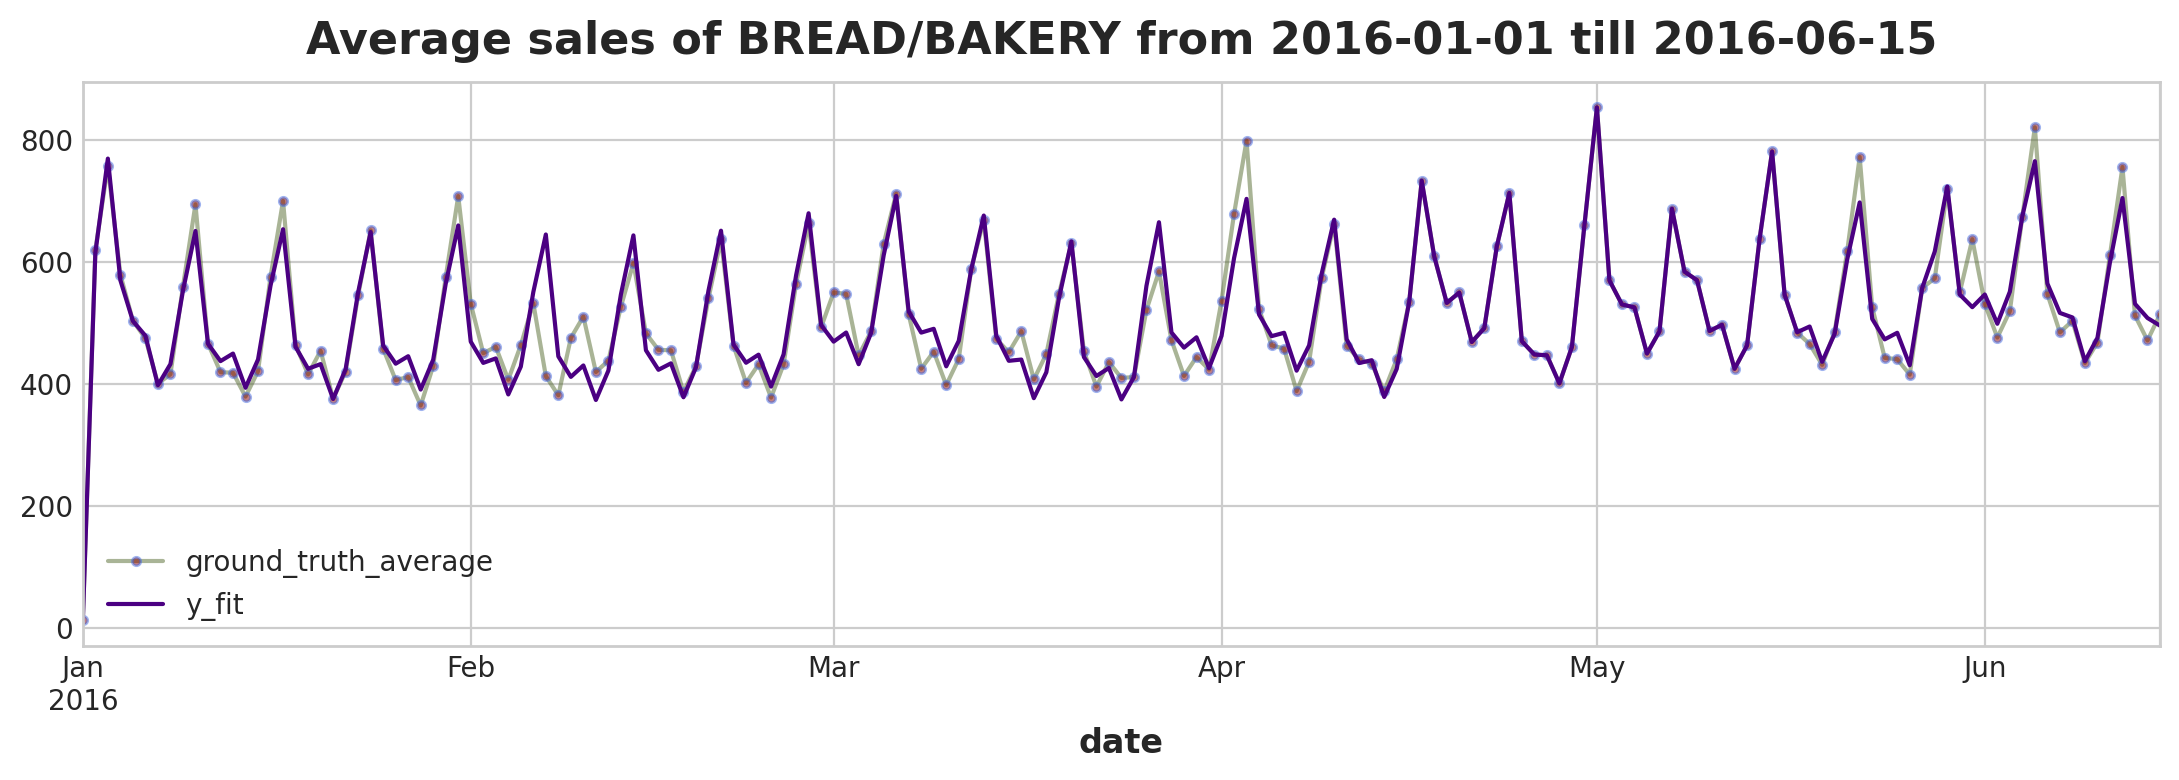

In [26]:
check(X_seasonal)

In [27]:
# seasonal_model = LinearRegression (fit_intercept = False).fit(X_seasonal, y_train)
# joblib.dump(seasonal_model, 'seasonal_model.pkl')

In [28]:
# Create features for test set

X_seasonal_test = dp.out_of_sample(steps=16)
X_seasonal_test.index.name = 'date'

# deseason with day_of_week
day_of_week = pd.Series(X_seasonal_test.index.dayofweek, index = X_seasonal_test.index)
X_day_of_week = pd.get_dummies(day_of_week, prefix = 'day_of_week')
X_seasonal_test = pd.concat([X_seasonal_test, X_day_of_week], axis=1)

# deseason with fourier
X_fourier_test = dp_fourier.out_of_sample(16)
X_seasonal_test = pd.concat ([X_seasonal_test, X_fourier_test], axis=1)

# deseason with holidays
X_seasonal_test.index.name = 'date'
X_seasonal_test = X_seasonal_test.join(X_holidays, on='date', how='left').fillna(0.0)

In [29]:
seasonal_model = joblib.load('/kaggle/input/timeseriescourse-models/seasonal_model.pkl')
y_seasonal_fore = pd.DataFrame(seasonal_model.predict(X_seasonal_test),               
                        index = X_seasonal_test.index,      
                        columns = y_train.columns).clip(0.0)

In [30]:
submission_1 = (y_seasonal_fore
            .stack(['family', 'store_nbr'])
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_1.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH VULCANO
- Public Score (RMSLE): **0.53218** (best result)

*A magnitude 7.8 earthquake struck Ecuador on `April 16, 2016`. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake*

## Add OHE for Eruption with 21-lags

In [31]:
def make_lags(ts, lags, prefix = None):
    return pd.concat({
            f'{prefix}_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

vulcano = pd.DataFrame((X_time.index == '2016-04-16')*1.0, index = index_, columns = ['vulcano'])
X_vulcano_ = make_lags (vulcano.squeeze(), lags = range(22), prefix = 'vulcano')
X_vulcano_ = X_vulcano_.fillna(0.0)

# Check
# start = pd.Period('2016-04-16', freq='D')
# X_vulcano.loc[start:start+21]

In [32]:
X_vulcano = pd.concat([X_seasonal, X_vulcano_], axis = 1)
X_vulcano.shape, X_vulcano.isna().sum().sum()

((1684, 131), 0)

Mean Squared Log Error: 0.06497


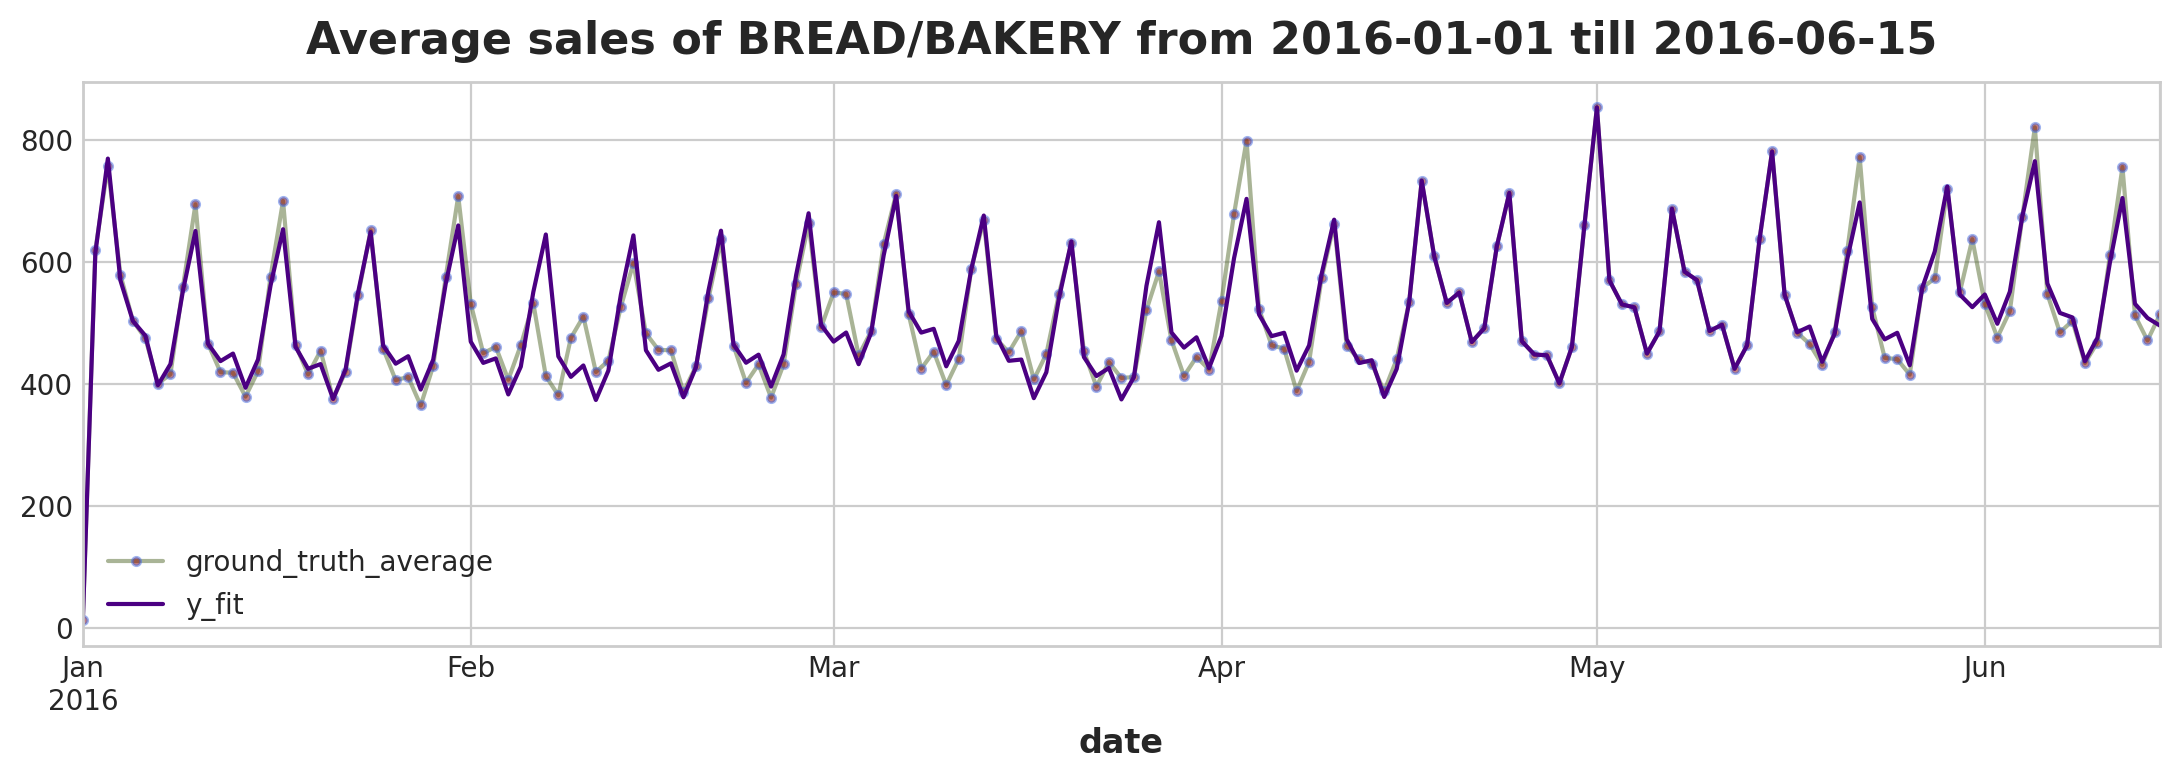

In [33]:
check(X_vulcano)

In [34]:
# vulcano_model = LinearRegression (fit_intercept = False).fit(X_vulcano, y_train)
# joblib.dump(vulcano_model, 'vulcano_model.pkl')

In [35]:
# add vulcano to the test set
X_vulcano_test = X_seasonal_test.join(X_vulcano_, on='date', how='left')
X_vulcano_test = X_vulcano_test.fillna(0.0)

X_vulcano_test.shape, X_vulcano_test.isna().sum().sum()

((16, 131), 0)

In [36]:
vulcano_model = joblib.load ('/kaggle/input/timeseriescourse-models/vulcano_model.pkl')
y_vulcano_fore = pd.DataFrame(vulcano_model.predict(X_vulcano_test),               
                        index = X_vulcano_test.index,      
                        columns = y_train.columns).clip(0.0)

In [37]:
submission_2 = (y_vulcano_fore
            .stack(['family', 'store_nbr'])
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
#best score
submission_2.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH MULTISTEP TARGET
- Public Score (RMSLE): **0.55745**

The training set ends on `2017-08-15`, which gives us the forecast **origin**.<br> The test set comprises the dates `2017-08-16` to `2017-08-31`, and this gives us the **forecast horizon**. <br>
There is one step between the origin and horizon, so we have a **lead time of one day**. <br>Put another way, we need a *`16-step forecast with a 1-step lead time`*.

# *A theoretical issue*: **Algorithm's Complexity**
Remember we said that to deal with temporal dependence with LinReg you need **X** and **y** that have simple PeriodIndex in axis=1. All other categories go 'wide' (axis=0). I think of this in a way that one row should contain everything that happened that day. <br>

Now, in our data set we have 54 stores and 33 'families' which brings us to their product - **1782** values per row in our initial BASELINE setting.<br>

What happens when we introduce multistep target? Exectly! We should multiply that number by the number of the steps. If we take 16 steps-forecast, then we will end up with **28 512** values per row, essentially meaning, that we will run **28 512** different regressions. 1 month forecast will cost us **53 460** parallel regressions at a time.

If I'm not mistaken, the Complexity of this algorithm can be described as:<br> 
                            
                            O(n*m*k)
                               
where:<br>
`n` - number of categorical features<br>
`m` - number of categories in each of the features <br>
`k` - number of your shifted features (lags, leads, rolling statistics)

In order to shrink down the numbers, you have 3 options:
1. Reduce `n` by averaging across some categories 
2. Reduce `m` by more coarse grouping
2. Reduce the number of steps in the forecast.

While 1. and 2. may be just meaningless, we will talk about №3 in the section **`Complexity Vs Error Propagation`**

In [38]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def check_multistep (
            data,    
            y = y_train,
            START = START, 
            END = END,
            FAMILY = FAMILY,
            STORE = STORE,
            EVERY = 16
):
       
    fit = (data
           .stack(['family', 'store_nbr'])
           .query('family == @FAMILY and store_nbr == @STORE')
           .reset_index(['family', 'store_nbr'], drop=True)
           .loc[START:END]
          )

    y = (y
         .stack(['family', 'store_nbr'])
         .to_frame()
         .query('family == @FAMILY and store_nbr == @STORE')
         .reset_index(['family', 'store_nbr'],drop=True)
         .rename(columns={0:'ground_truth'})
         .loc[START:END]
         .squeeze()
        )

    fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    ax = y.plot(**plot_params, ax=ax, alpha=0.5)
    ax = plot_multistep(fit, ax=ax, every=EVERY)
    ax.set_title (f'16-days forecasts against ground-truth for {FAMILY} from {START} till {END}')
    
# Takes one forecast on START day and renames all 'lag_{i}' columns by corresponding dates.     
def fetch_forecast (
        data,
        START = '2017-08-16',
        END = '2017-08-31'):
    
    X = data.loc[START]
    DATES = pd.period_range (START, END)                                # this is needed for iteration through a list of all 
    index_to_rename = X.index.get_level_values(0).unique()[:len(DATES)] # dates in the horizon (when calculating an average)
    rename_dict = dict(zip(index_to_rename, DATES))

    forecast = X.rename(rename_dict, level = 0).to_frame()
    forecast.index = forecast.index.set_names('date',level = 0)
    
    return forecast

In [39]:
# It gets shorter after dropping NANs. Hence are all further '.align()' methods
y_train_multi = make_multistep_target(y_train, steps=16).dropna() 

In [40]:
y_train_multi, X_vulcano_cut = y_train_multi.align(X_vulcano, join='inner', axis=0)

In [41]:
# X_vulcano_cut has 'const' column, which works to calculate y-intercept
# model_multi = LinearRegression (fit_intercept = False).fit(X_vulcano_cut, y_train_multi)
# joblib.dump(model_multi, "model_multi.pkl")

In [42]:
model_multi = joblib.load('/kaggle/input/timeseriescourse-models/model_multi.pkl')
y_multi_fit = pd.DataFrame(model_multi.predict(X_vulcano_cut),               
                        index = X_vulcano_cut.index,      
                        columns = y_train_multi.columns).clip(0.0)

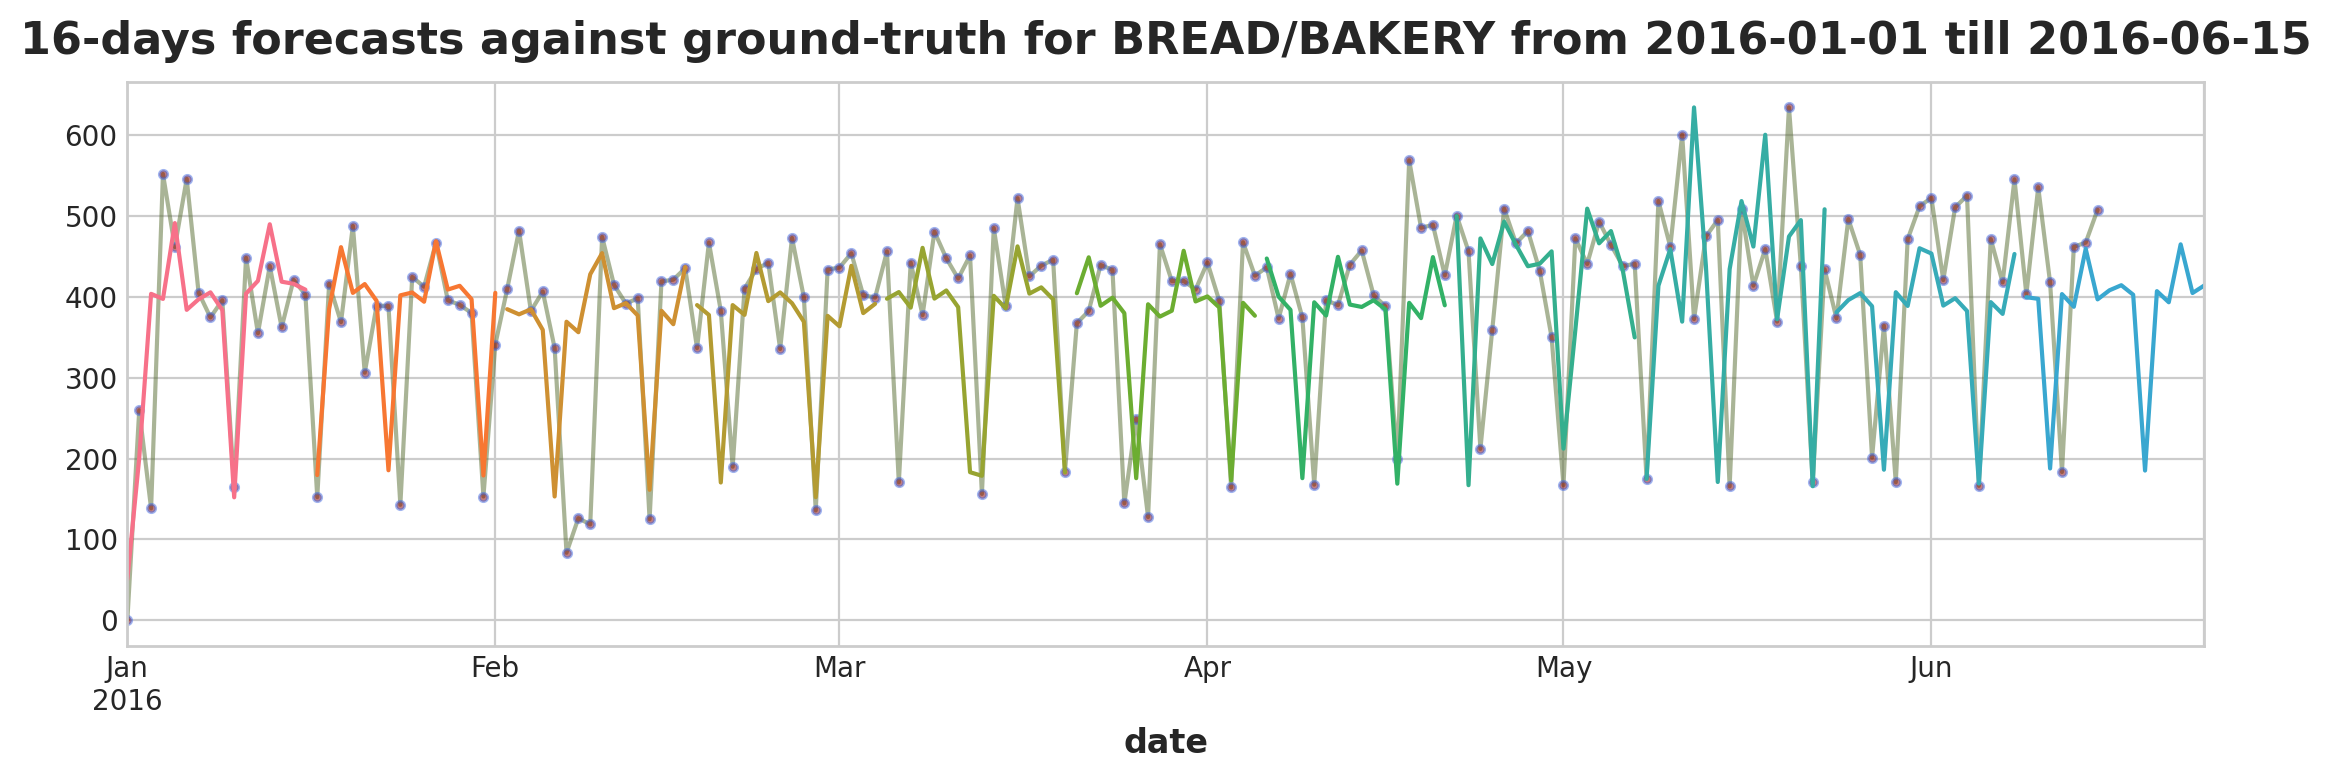

In [43]:
check_multistep (y_multi_fit)

In [44]:
y_multi_fore = pd.DataFrame(model_multi.predict(X_vulcano_test),               
                        index = X_vulcano_test.index,      
                        columns = y_train_multi.columns).clip(0.0)

In [45]:
submission_3 = (fetch_forecast(y_multi_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_3['sales'] = submission_3.iloc[:,0]
submission_3 = submission_3[['id','sales']]
# submission_3.to_csv('/kaggle/working/submission.csv', index=False)

## Bonus: forecasts averaged
- Public Score (RMSLE): **0.55769** (no improvement)

In [46]:
'''
This is where we iterate through a list of dates, fetching forecasts and renaming their 
'lag_{i}' columns with pertinent dates
'''
range_ = [str(period) for period in pd.period_range ('2017-08-16', '2017-08-31')]
forecasts = [fetch_forecast (y_multi_fore, START=i) for i in range_]

In [47]:
# Nice tool from the course. Here is how it may be applied
import ipywidgets as widgets

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(forecasts)])
for i, df in enumerate(forecasts):
    data_tabs.set_title(i, f'forecast {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

In [48]:
full = forecasts[0]

for forecast in forecasts[1:]:
    full = full.merge(forecast, left_index=True, right_index=True, how='left')

submission_4 = pd.DataFrame (full.mean(axis=1), columns = ['sales'])
submission_4 = submission_4.join(test.id).reset_index(drop=True)
# submission_4.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH BOOSTED HYBRID
- Public Score (RMSLE): **0.55867**

In [49]:
"""
While the linear regression algorithm is capable of multi-output regression, 
the XGBoost algorithm is not. To predict multiple series at once with XGBoost, 
we'll instead convert these series from wide format, with one time series per column, 
to long format, with series indexed by categories along rows.
"""

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          # make predictions with self.model_1
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
        y_resid = y - y_fit                             # compute residuals
        y_resid = y_resid.stack([0,1])                  # wide to long. (level=[0,1]) - to pivot both 'family' and 'store_nbr'
        
        X_2_train, X_2_val, y_resid_train, y_resid_val = train_test_split(X_2, y_resid, test_size=0.2, shuffle=False)

        self.model_2.fit(X_2_train, y_resid_train,     # fit self.model_2 on residuals
                         early_stopping_rounds=5,      # This is an XGB feature
                         eval_set=[(X_2_val, y_resid_val)], # that works in pair with this one
                         verbose=False)

        self.y_columns = y.columns                     # Save column names for predict method
        self.y_fit = y_fit                             # Save data
        self.y_resid = y_resid
        
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
        y_pred = y_pred.stack([0,1])
        y_pred += self.model_2.predict(X_2)
        
        return y_pred

In [50]:
'''
As soon as we have 'early_stopping' hyperparameter for XGB, 
the value of 'n_estimators' becomes less significant. 
'''
model_BH = BoostedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
)

In [51]:
"""
So that XGBoost can learn to distinguish between FAMILIES and STORES, 
we'll duplicate these levels of MultiIndex with categorical features with a label encoding. 
"""

from sklearn.preprocessing import LabelEncoder

X_2 = train[['onpromotion']]

le_family = LabelEncoder()
X_2['family_fact'] = X_2.index.get_level_values('family')
X_2['family_fact'] = le_family.fit_transform(X_2['family_fact'])
X_2['store_fact'] = X_2.index.get_level_values('store_nbr').astype(int)

In [52]:
X_2_test = test[['onpromotion']]

X_2_test['family_fact'] = X_2_test.index.get_level_values('family')
X_2_test['family_fact'] = le_family.transform(X_2_test['family_fact'])
X_2_test['store_fact'] = X_2_test.index.get_level_values('store_nbr').astype(int)

In [53]:
# model_BH.fit(X_vulcano, X_2, y_train)
# joblib.dump (model_BH, 'BoostedHybrid.pkl')

In [54]:
model_BH = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybrid.pkl')
y_BH_fit = model_BH.predict(X_vulcano, X_2).to_frame().clip(0.0)

Mean Squared Log Error: 0.33090


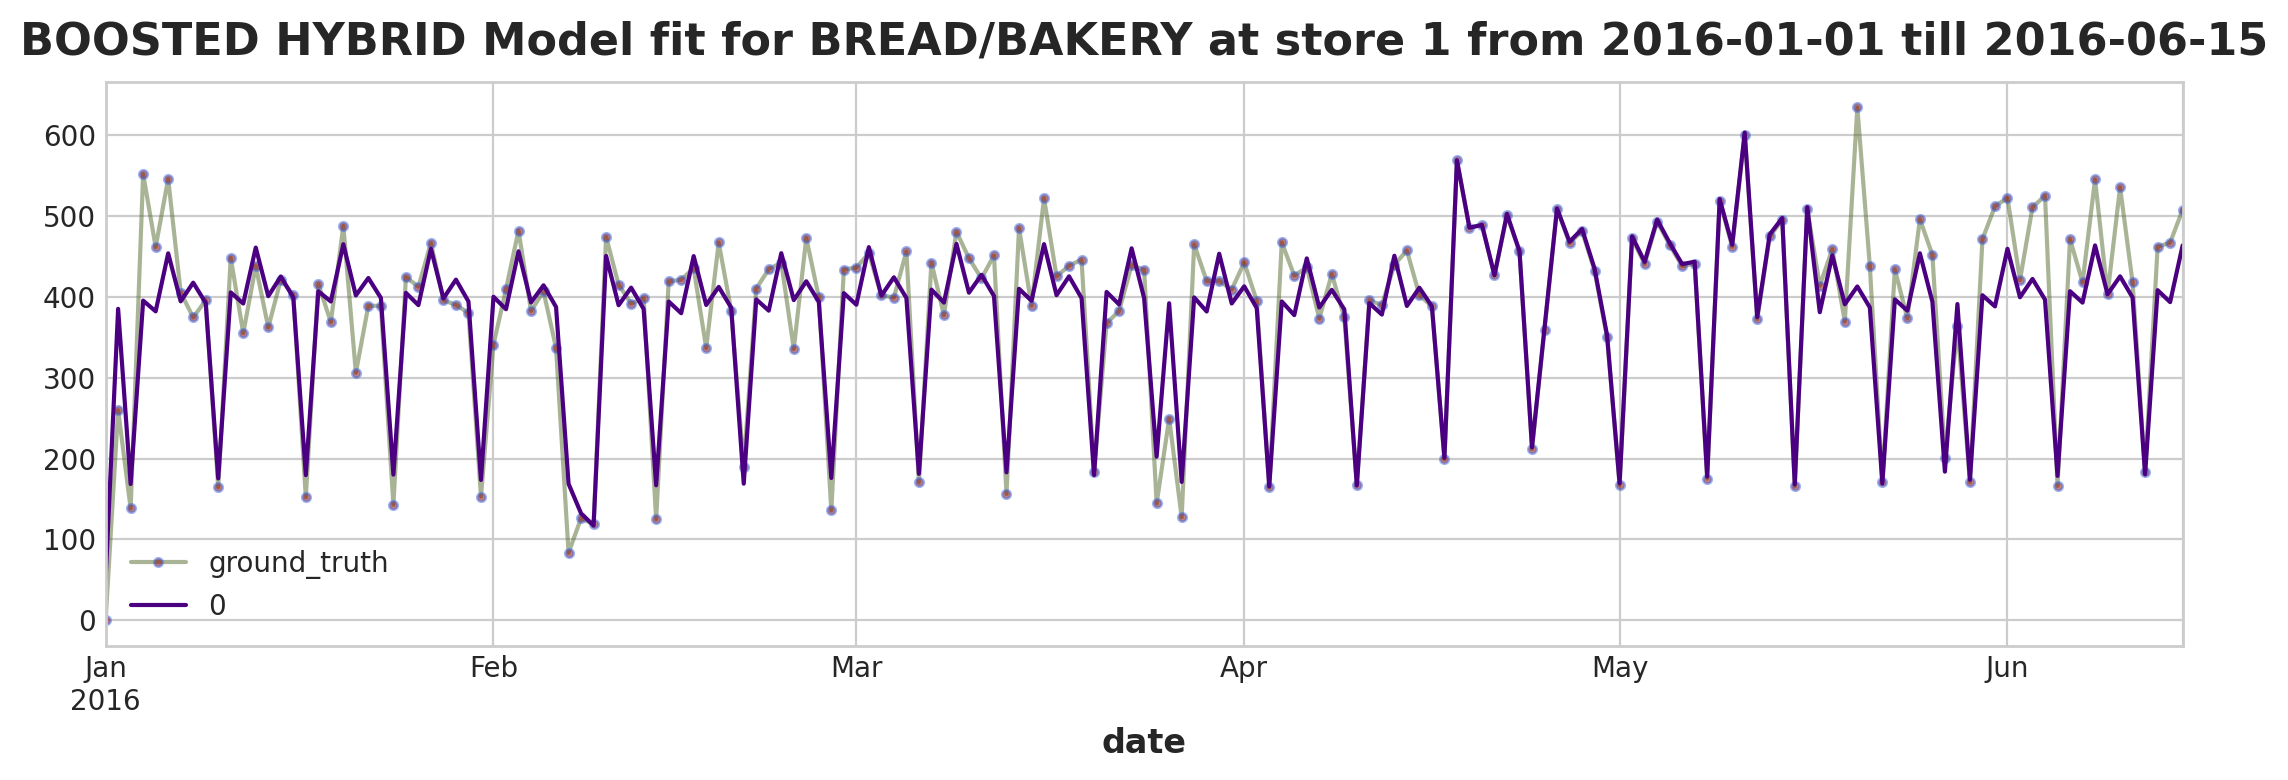

In [55]:
"""
Here we pass the models' fit TO the ckeck() function, 
so no fitting INSIDE of the function is required.
"""
check (y_BH_fit, 
       y = y_train, 
       STORE = STORE, 
       FIT=False, 
       Prefix = f'BOOSTED HYBRID Model fit')

In [56]:
y_BH_fore = model_BH.predict(X_vulcano_test, X_2_test).clip(0.0)

In [57]:
submission_5 = (y_BH_fore 
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_5.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH STACKED HYBRID
- Public Score (RMSLE): **0.53234**

In [58]:
''' 
It's similar to the boosted model above, with one key difference: 
We include model_1's prediction as a feature in X_2_train instead of subtracting it from y_train.
'''
class StackedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
    
        y_long = y_fit.stack(level=[0,1])              
        
        X_2 = pd.concat([X_2, y_long], axis=1)         # HERE IS WHY THE MODEL IS STACKED
            
        X_2_train, X_2_val, y_long_train, y_long_val = train_test_split(X_2, y_long, test_size=0.2, shuffle=False)

        self.model_2.fit(X_2_train, y_long_train,     
                         early_stopping_rounds=3,       
                         eval_set=[(X_2_val, y_long_val)], 
                         verbose=False)

        self.y_columns = y.columns                    
        self.y_fit = y_fit                           
        self.y_long = y_long
        
        
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
        y_pred = y_pred.stack([0,1])
        
        X_2_augm = pd.concat([X_2, y_pred], axis=1)
        
        y_pred_2 = pd.Series(
            self.model_2.predict(X_2_augm),
            index=X_2.index)
        
        return y_pred_2

In [59]:
model_SH = StackedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=XGBRegressor(n_estimators = 50, learning_rate=0.05, n_jobs=4)
)

In [60]:
# model_SH.fit(X_vulcano, X_2, y_train)
# joblib.dump (model_SH, 'StackedHybrid.pkl')

In [61]:
model_SH = joblib.load('/kaggle/input/timeseriescourse-models/StackedHybrid.pkl')
y_stacked_hybrid_fit = (model_SH
                    .predict(X_vulcano, X_2)
                    .to_frame()
                    .rename(columns = {0: 'STACKED HYBRID fit'})
                   )

Mean Squared Log Error: 0.33306


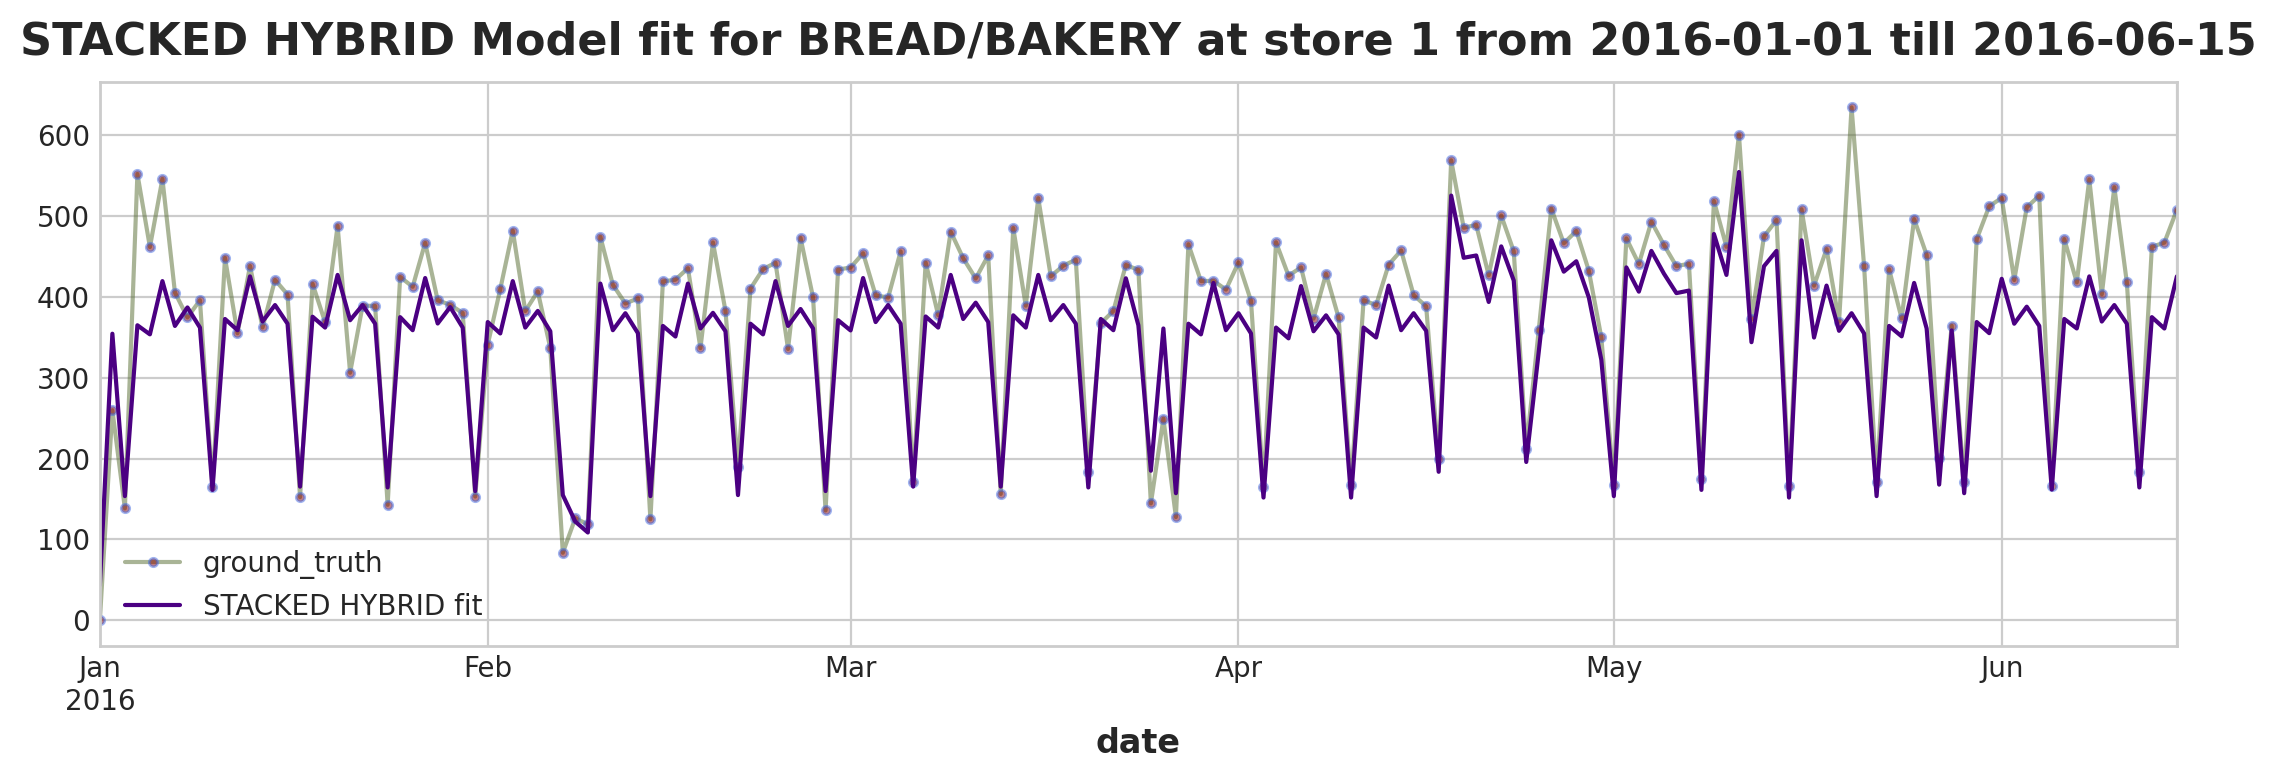

In [62]:
"""
Boosted Hybrid looked better
"""
check (y_stacked_hybrid_fit, 
       y = y_train, 
       STORE = STORE, 
       FIT = False,
       Prefix = f'STACKED HYBRID Model fit'
      )

In [63]:
y_stacked_hybrid = model_SH.predict(X_vulcano_test, X_2_test).clip(0.0)

In [64]:
submission_6 = (y_stacked_hybrid
            .to_frame()
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )
# submission_6.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH BOOSTED HYBRID AND MULTISTEP TARGET
- Public Score (RMSLE): **0.79814**

# *A theoretical issue*: **Complexity Vs Error Propagation**

**four common strategies**
The course introduces 4 theoretical consepts of forecasting:<br>
*Multioutput model, Direct Strategy, Recursive Strategy* and *DirRec Strategy*.

In my humble opinion, there are only two real concepts here:

1. `Multioutput model` and `Direct Strategy` **is the same thing**. Even if we make one .fit() in our code, we are still running as many models as there are steps in `y`. No matter what model we use. Even Neural Networks in their multiple outputs produce destribution of a probability (which is 1 destributed among all the classes). No model can give you several UNRELATED values in an output. Otherwise, how should your Error Function work? **Please, correct me if I am wrong**

2. `Recursive Strategy` and `DirRec Strategy` is also **the same thing**. You give a forecast as input to your model to make a new forecast. The difference is how many steps your `y` has, how many you give the model at a time. If one - it's *recursive*, if several - it's *DirRec*. In my humble opinion, it is the same strategy and the number of steps is just a Complexity Vs Error compromise, informed by computation resourses at your disposale.

**Error Propagation**
When you pass a LinReg's own prediction as an input to itself multiple times, you can calculate the error accumulation as a progression. This allows you to create a statistically supported Confidence Interval for your forecast. However, if you do the same with XGBoost, you can't estimate the accumulated error because XGBoost doesn't rely on functional dependencies. It only knows that when `X` is **A**, `y` should be somewhere close to **B** and when `X` is **A1**, `y` should be somewhere close to **B2**. The difference between A1 and A2 may be very small, and the difference between B1 and B2 can be significant, and it won't be the same for the next interval. So when your erroneous input randomly assumes the value of A2, your model's output goes crazy. And then you feed that sick output back to the model for the next prediction. 

My assumption is that error propagation with XGBoost is unpredictable or ridiculously complex to control. And this is why you would want to avoid or at least minimize it as much as possible.

How can you do that? By reducing the number of fits with forecasts. And here comes the **trade off**:
1. Idially, you would want your model to produce a forecast for the entire horizon (all 16 days at once in our case). But each day is another model, which may be too much for your hardware.
2. If you predict for one day only and then staff XGB with it's own error 16 times in a line, it will give you garbage in the end.
3. The compromise is to make as long a MultiStep Target, as your machine can handle and to reduce the number of iterations where forecasts are fed back into the model as much as possible. For example, if you can't afford a 16-day forecast all at once, you can create an 8-day forecast with only one (re)fitting iteration. 

Therefore, the 'DirRec strategy' appears more as a technical decision rather than a strategy in the traditional sense. It's akin to adjusting the size of your training set to match your computational capabilities. 

**Please share your ideas about these considerations**

In [65]:
class MultiBoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.y_columns_stacked = None                   # This is NEW
        
    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(                          
                    self.model_1.predict(X_1),
                    index=X_1.index, 
                    columns=y.columns
        )
        y_resid = y - y_fit                             
        y_resid = y_resid.stack(['family','store_nbr']) # Specified level names explicitly to avoid confucion. 
                                                        # Otherwise 'lags' may go 'wide'.
        
        self.model_2.fit(X_2, y_resid )                 

        self.y_columns = y.columns                      
        self.y_columns_stacked = y_resid.columns
        
        self.y_fit = y_fit                           
        self.y_resid = y_resid
        
        
    def predict(self, X_1, X_2):
        y_pred_1 = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
            columns=self.y_columns,
        )
                
        y_pred_2 = pd.DataFrame(
            self.model_2.predict(X_2),
            index=X_2.index, 
            columns=self.y_columns_stacked            # Here is where this NEW is required. 
        )
        
        y_pred_1 = y_pred_1.stack(['family','store_nbr'])
        
        y_pred = y_pred_1 + y_pred_2
        
        return y_pred

In [66]:
"""
RegressorChain is necessary to run 16 parallel XGB models for the lags of our MultiStepTarget. 
However,it doesn't seem to work well with EarlyStopping. 
As a result, the Hybrid model turned out a bid simplistic.
"""
from sklearn.multioutput import RegressorChain

model_MBH = MultiBoostedHybrid(
            model_1=LinearRegression(fit_intercept = False),
            model_2=RegressorChain(
                XGBRegressor(n_estimators = 10,        #It's an exemplary model. Let it be fast and small 
                             max_depth=3, 
                             learning_rate=0.1, 
                             n_jobs = 8)
            )
)

In [67]:
# lets reduce the training set down to 2 years
idxmicro_ = index_[:730]              
X_vulcano_micro = X_vulcano_cut[X_vulcano_cut.index.isin(idxmicro_)]
y_train_multi_micro = y_train_multi[y_train_multi.index.isin(idxmicro_)]

In [68]:
"""
X_2 is for XGB. It is in 'long' format 
"""
X_2 = X_2.unstack(['family', 'store_nbr'])                              # X_2 turns 'wide' first                
X_2_micro, y_train_multi_micro = X_2.align(y_train_multi_micro,         # then it aligns dates with y, which is in 'long' format
                                           join='inner', 
                                           axis=0) 
X_2_micro = X_2_micro.stack(['family', 'store_nbr'])                    # and goes back to 'long'    
X_2_test = X_2_test[['family_fact','onpromotion','store_fact']]         # correct features' order

In [69]:
# model_MBH.fit(X_vulcano_micro, X_2_micro, y_train_multi_micro)
# joblib.dump (model_MBH, 'BoostedHybridMulti.pkl')

In [70]:
model_MBH = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybridMulti.pkl')
y_MBH_fit = pd.DataFrame(model_MBH.predict(X_vulcano_micro, X_2_micro),
                         index = X_2_micro.index
                        ).clip(0.0).unstack(['family','store_nbr']) 

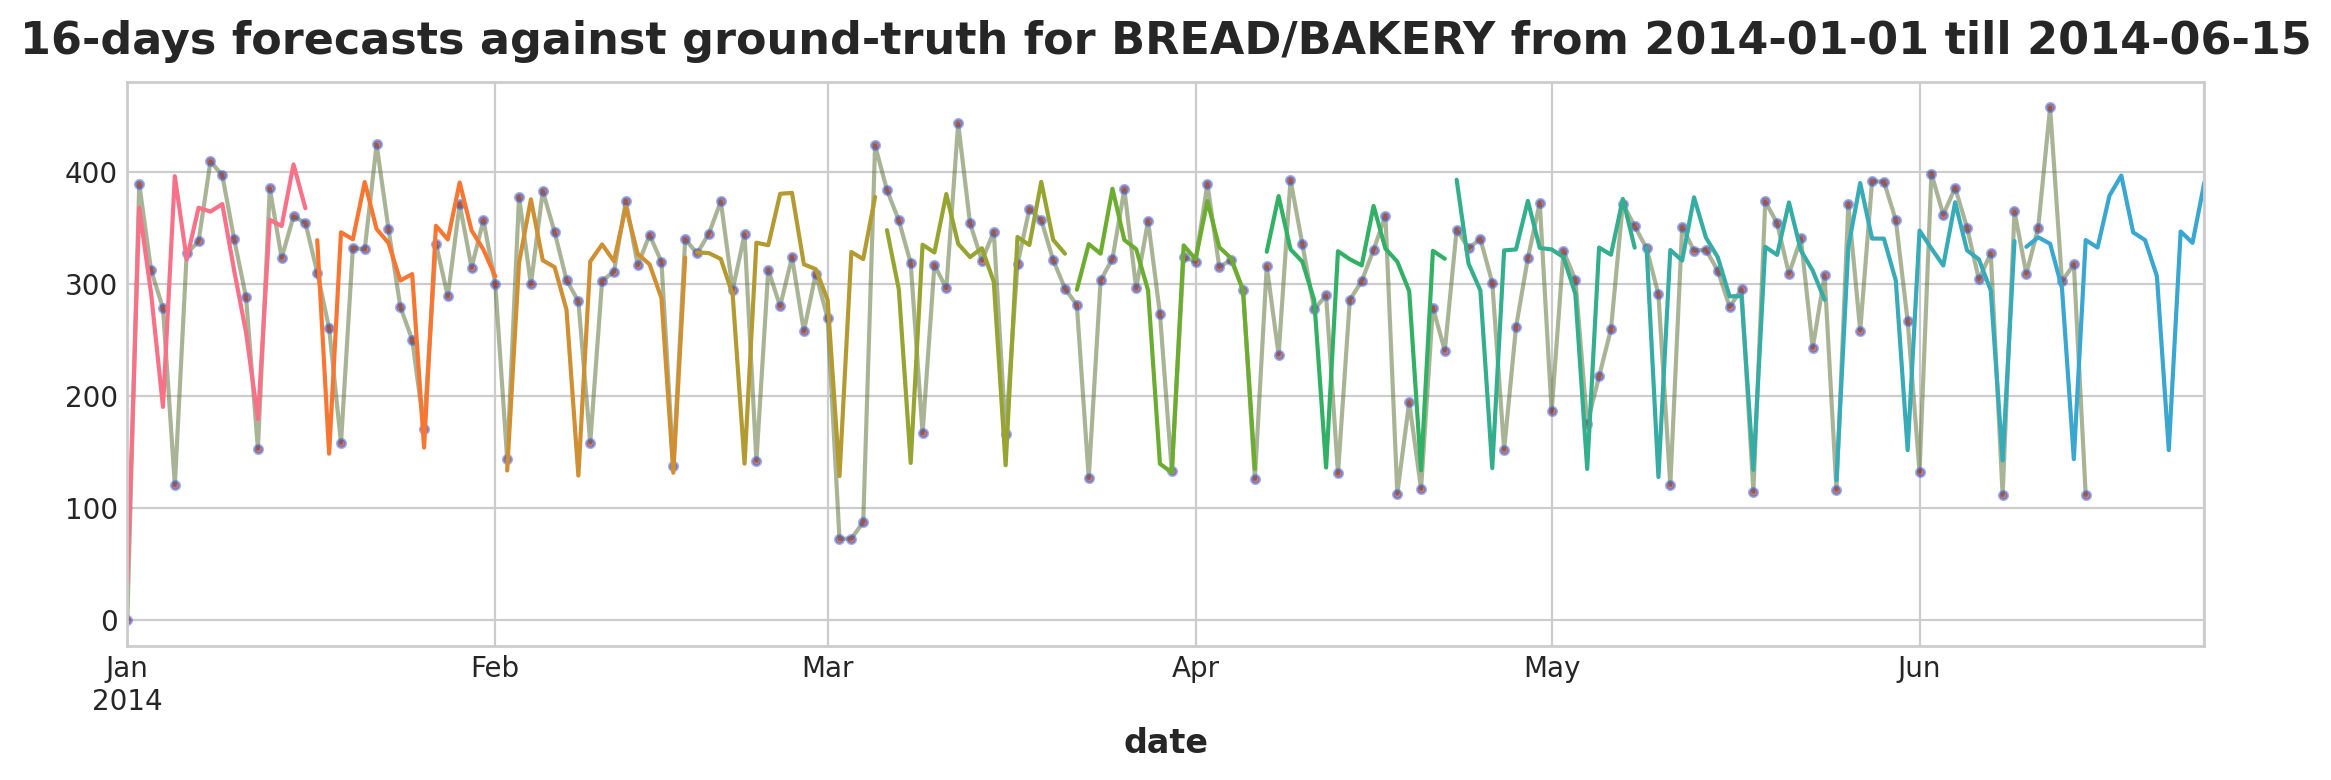

In [71]:
check_multistep (y_MBH_fit,
                START = '2014-01-01', 
                END = '2014-06-15')

In [72]:
y_MBH_fore = pd.DataFrame(model_MBH.predict(X_vulcano_test, X_2_test),               
                        index = X_2_test.index
                    ).clip(0.0) 
y_MBH_fore = y_MBH_fore.unstack(['family', 'store_nbr'])

In [73]:
submission_7 = (fetch_forecast(y_MBH_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_7['sales'] = submission_7.iloc[:,0]
submission_7 = submission_7[['id','sales']]
# submission_7.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH BOOSTED HYBRID, MULTISTEP AND CYCLES
- Public Score (RMSLE): **0.5607**

# *A theoretical issue*: **Model's Architecture**

Here comes another subtle point in understanding the nature of the whole process. <br>
LinReg and XGB are not just two interchangeable options in your pipeline. They are different tools taking different input data in different format at different stages. I've spent days getting my head around it and going many eroneous ways mixing things up, which led me each time to crazy dimentionality, complexity and low metrics.

**LineRegression**
The features you give to LinReg are ALL products of your excersises with PeriodIndex: time-dummy, fourier, OHE for specific occasions - all these are made from PeriodIndex.
You give it to your LinReg in **wide** format (`unstack()`), where each row corresponds a date: both in X and y. No matter what you want to achieve, you should squeeze it in one row per day. 
You then fit the LinReg model using X and y, and subsequently, you .predict() with the same X to get y_fit. You subtract y_fit from the original y. Now you have the RESIDUALS that XGB will learn. 

**XGBoost**
All other features, including products of your excersices with the target (lags, rolling statistics, etc), literally ALL OTHER features - you give them to your XGB as input to learn the RESIDUALS.
You provide them to XGB in **long** format using `.stack()`. Why? Because you essentially have as many models as there are columns in 'y'. Running 1782 linear regressions simultaneously (wide format) is one thing, but running 1782 parallel Gradient Boosting Tree models is entirely different. Given your resources, you can afford to run 16 XGB models at once, corresponding to the steps in your forecast (long format). 

**Target's shifts and MultiStep target**
When you shift values from the training data, you have data for as many days as your smallest lag. For example, with lag_1, you have data to shift for tomorrow. However, you already lack data for the day after tomorrow because what will be tomorrow is unknown, and there's nothing to shift. If your smallest lag is lag_2, then you have X_test for 2 days, etc.

However, given the fact that the shifts should be informed by the *`Autocorrelogram`*, rather then you coding convenince, you have a given set of lags (no matter what you shift there: rolling stats, target values or else).

Your purpose in this case will be to make all the shifted data meet **some shiny day in one row** of your 'wide' table to make **`X_test`** complete. And what do you want the model to give you in exchange for that 1 day data? Exactly! A forecast for the next 16 days.

So, if picturing it in a 'wide table' format you are passing one row of the data shifted from the training set to get one row of data as a 16 days forecast. And this is why you need to train your model to do that. **This is why you make MultiSteps Target** and teach your model to learn values for 16 days at once. It's all in the sake of that **Big Forecast Day**.

**Last, but not least**. Your picture of a 'wide table' is for you only. When you fetch your X_test, don't forget to .stack() it, because this is how your XGB likes it. 

**P.S.** A recurrent re-fitting with 1-step forecasts (direct strategy) is still an option, when using shifts. And it is still bad one.

In [74]:
"""
I obtained these functions with 'inspect' from the course. You're welcome!
"""

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText                       #
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    
    scatter_kws = dict(
        alpha=0.75,                            # alpha - transparence
        s=3,                                   # s - size of the dots
    )
    line_kws = dict(color='C3', )              # colore of the line
    
    ax = sns.regplot(x=x_,                     # time series x_
                     y=y_,                     # lagged series y_
                     scatter_kws=scatter_kws,  
                     line_kws=line_kws,
                     lowess=True,              # Locally Weighted Scatterplot Smoothing (makes the line bend to better adjust the relation)
                     ax=ax,
                     **kwargs)
    at = AnchoredText(                         # Annotation with correlation level
        f"{corr:.2f}",
        prop=dict(size="large"),               # This sets the properties of the text, specifying the font size as "large."
        frameon=True,                          # frame around the annotation box.
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")   # sets the style of the annotation box (quare with no padding)
    ax.add_artist(at)                          # This line adds the AnchoredText object (at) to the plot (ax)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)                               # sets the x-label for the last row of subplots to the name of the x series
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)   # sets the y-label for the first column of subplots to the name of the y series (if any)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

Lag plots for BREAD/BAKERY at store 1 from 2016-01-01 till 2016-06-15


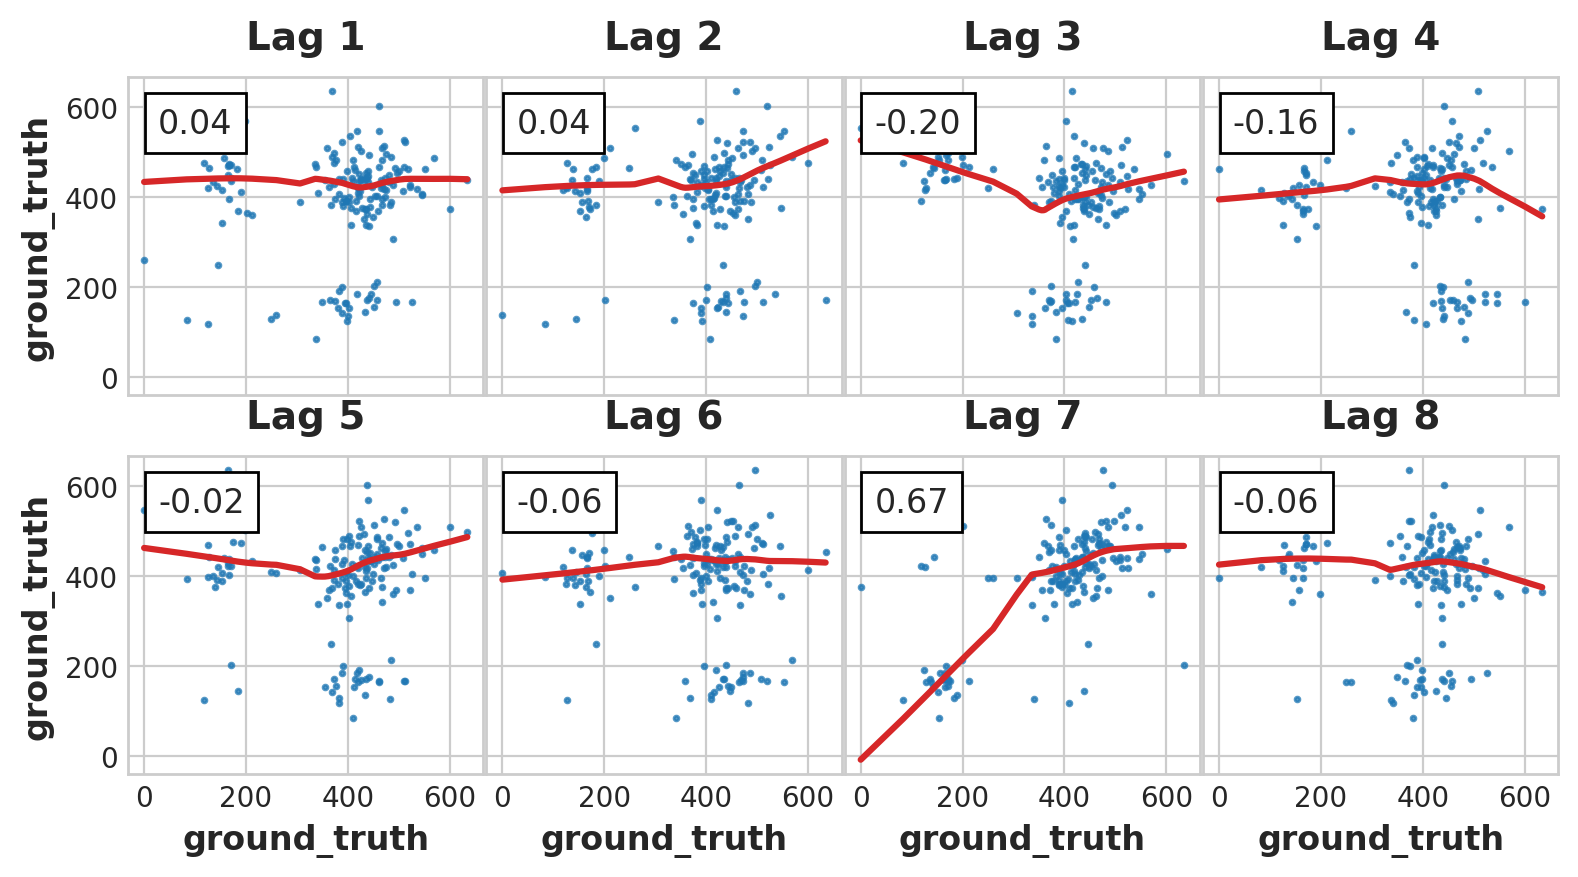

In [75]:
"""
These plots are based on your selections: family, store, and dates. 
I've experimented with various combinations, and they all yield different results. 
This suggests there's no relationship between the demand for bikes and frozen pizza across the country. 
These plots serve more as utility tools here than a visualization of informed decisions.
"""

print (f'Lag plots for {FAMILY} at store {STORE} from {START} till {END}')
_ = plot_lags(y_true, lags=8, nrows=2)

Partial Autocorrelation for BREAD/BAKERY at store 1 from 2016-01-01 till 2016-06-15


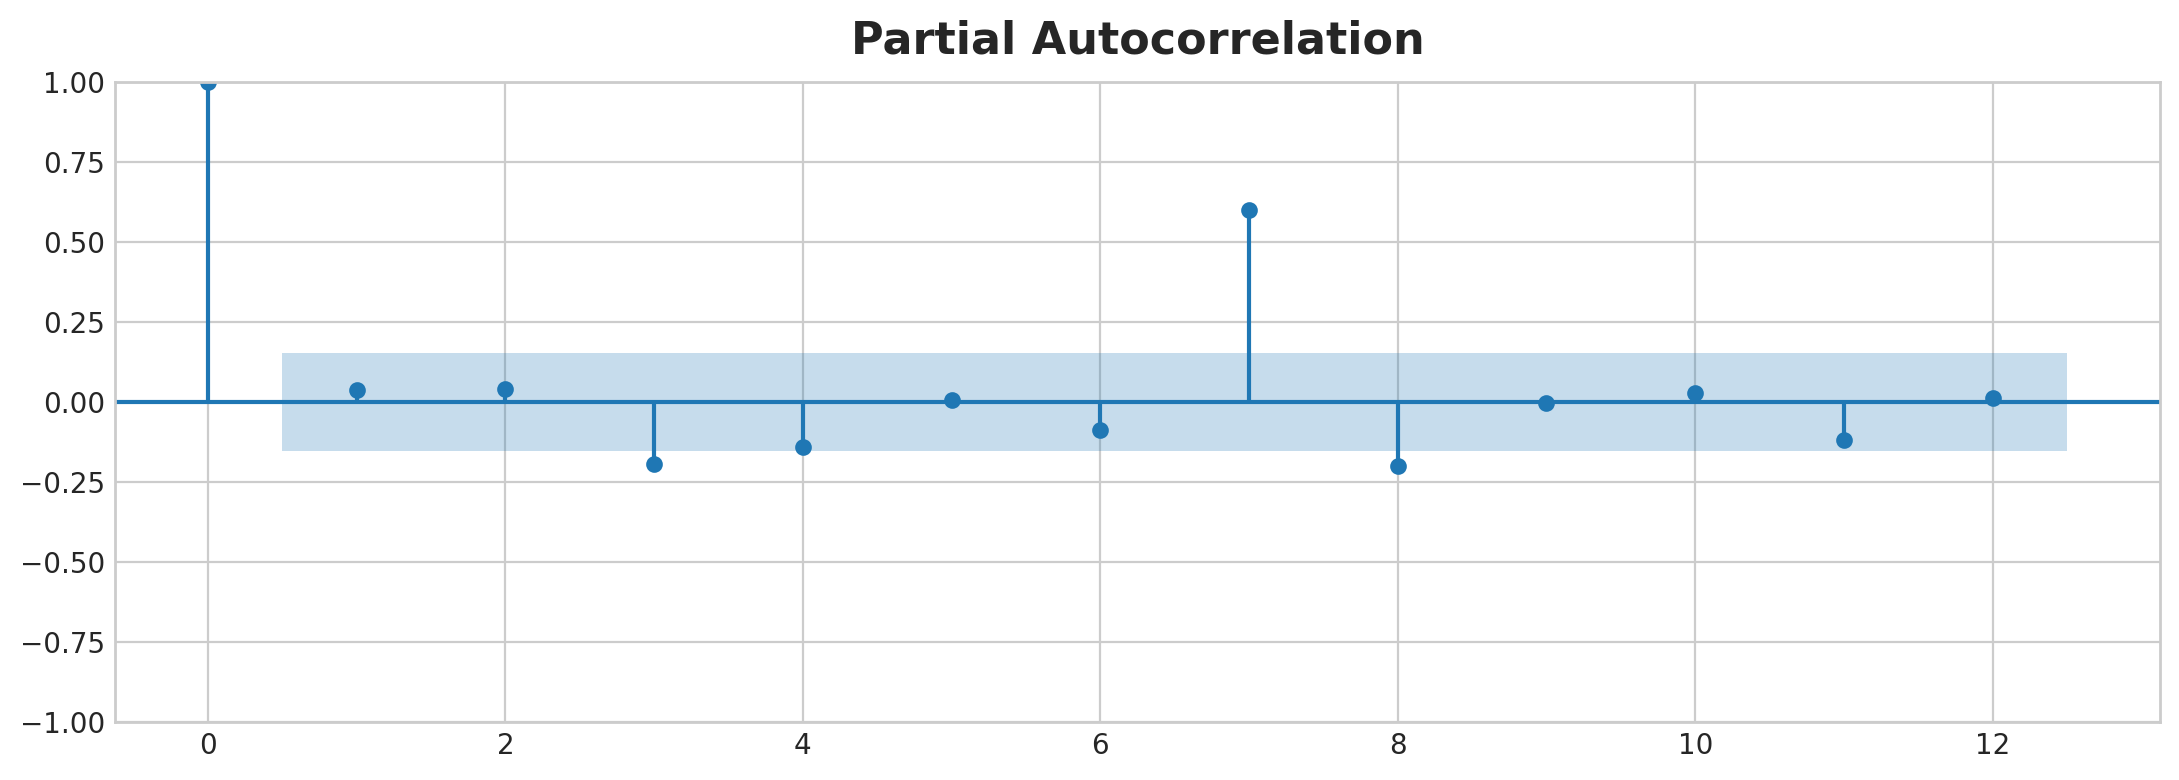

In [76]:
from statsmodels.graphics.tsaplots import plot_pacf
print (f'Partial Autocorrelation for {FAMILY} at store {STORE} from {START} till {END}')
_ = plot_pacf(y_true, lags=12)

## Add three lags for 'sales'
The course used three lags, so let's stay consistent with that number.

In [77]:
"""
First, we need to merge 'train' and 'test'. Otherwise, there won't be where to shift lags and leads. 
Simply put, for us to make lag_1, i.e. shift 'sales' value from '2017-08-15' (end of 'train' sample)
to '2017-08-16' (begin of the 'test' sample), those dates should be in on DataFrame 
"""
X_merged = pd.concat([train, test])
index_merged = X_merged.index.get_level_values('date').unique()
y_train_merged = (X_merged
                 .unstack(['family', 'store_nbr'])
                 .loc[:,"sales"]
                )

In [78]:
'''
As previously explained, the shifts (lags and leads) should be made per ['family', 'store_nbr'] group.
X_control is taken to see the picture of accuratelly lagged values (per group)
'''

def make_lags(ts, lags, prefix = None):
    return pd.concat({
            f'{prefix}_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

lags = [1,2,3]
X_lags = (X_merged
        .groupby(['family', 'store_nbr'])['sales']
        .apply(make_lags, lags=lags, prefix = 'sales')
        .fillna(0.0)
         )

# Check
# X_control = X_merged.query('family == @FAMILY and store_nbr == @STORE')
# X_lags.loc[X_control.index]

Mean Squared Log Error: 0.02762


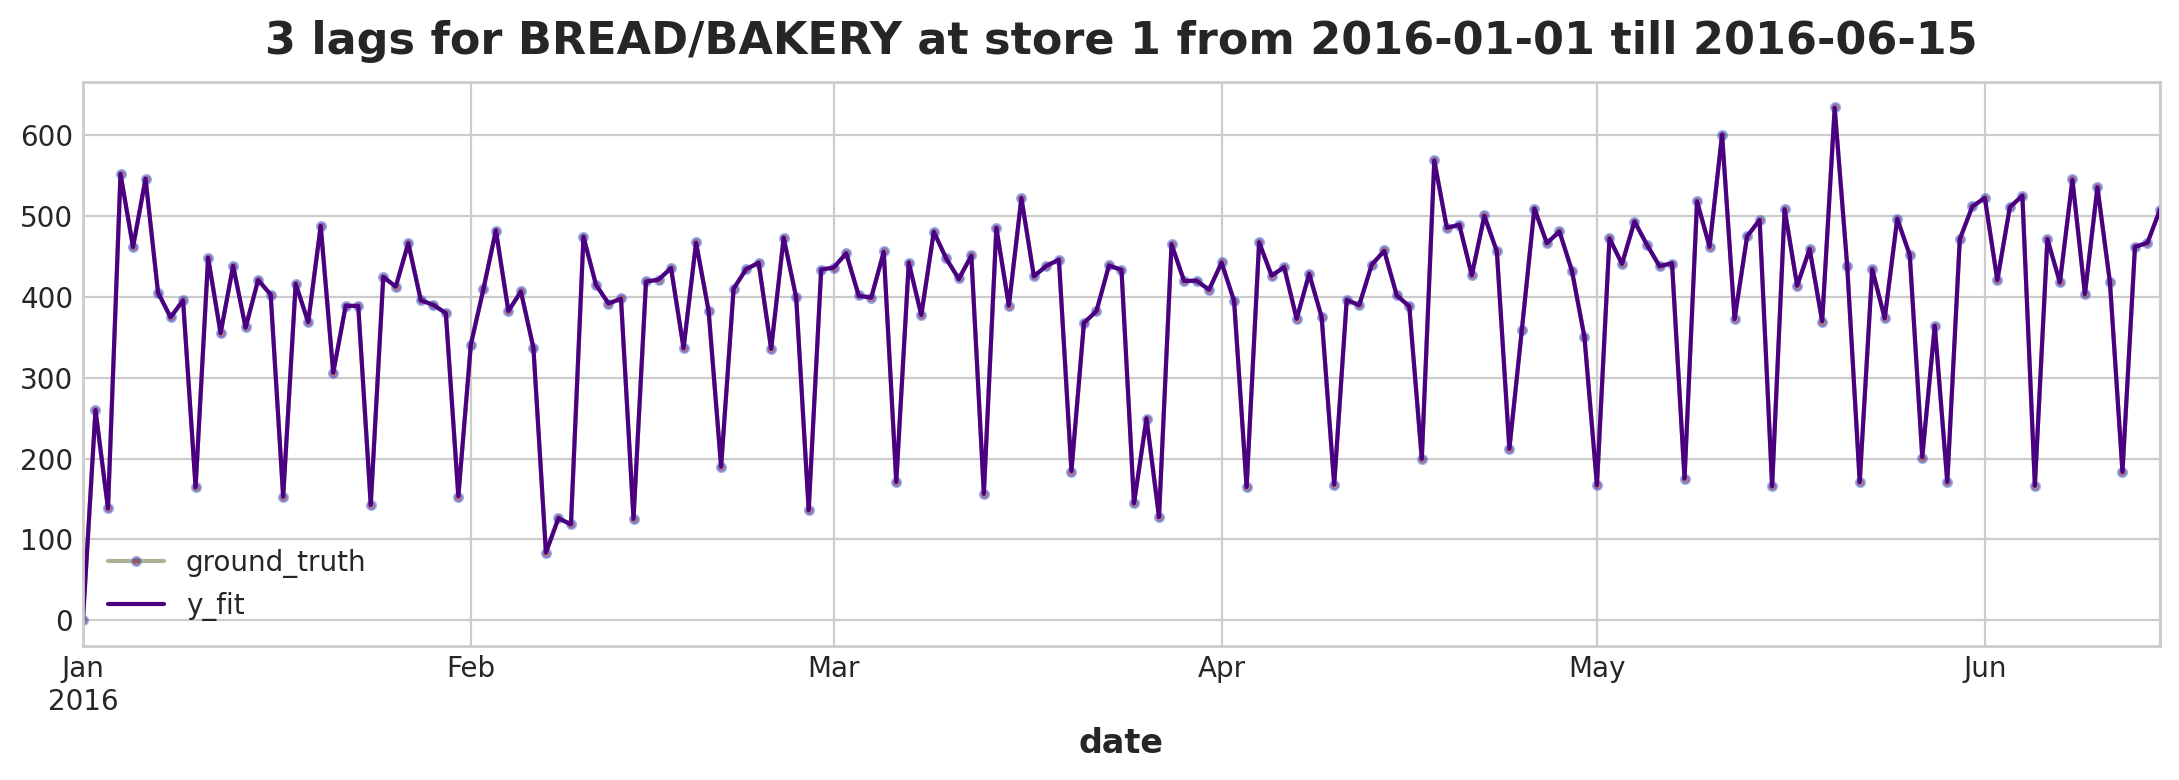

In [79]:
'''
Such an ideal match may only imply overfitting.
In other cicumstances it would be worth a cross-validation check
'''
check (X_lags, 
       y= y_train, 
       STORE = STORE,
       model = XGBRegressor(),
       Prefix = '3 lags')

## Add three leads for 'onpromotion'

In [80]:
def make_leads(ts, leads, prefix = None):
    return pd.concat({
            f'{prefix}_lead_{i}': ts.shift(-i)
            for i in leads
        },
        axis=1)


leads = [1,2,3]
X_leads = (X_merged
           .groupby(['family', 'store_nbr'])['onpromotion']
           .apply(make_leads, leads=leads, prefix= 'onpromotion')
           .fillna(0.0)
          )

# Check
# X_control = X_merged.query('family == @FAMILY and store_nbr == @STORE')
# X_leads.loc[X_control.index]

Mean Squared Log Error: 0.30916


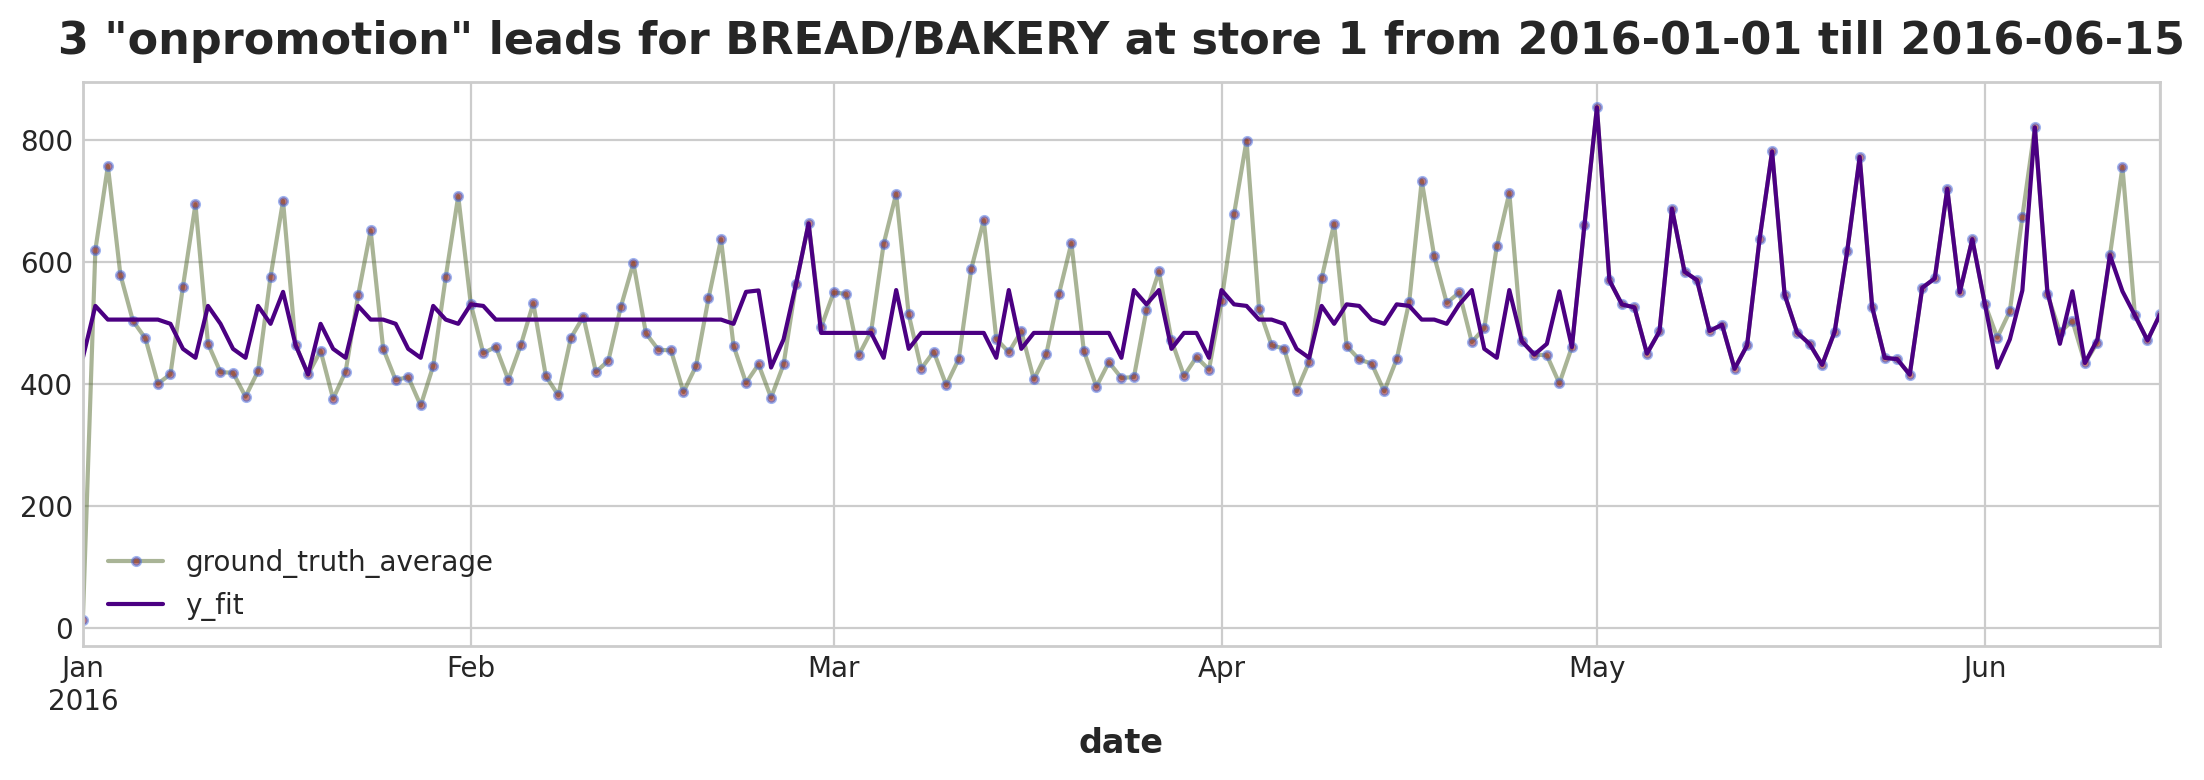

In [81]:
"""
Try several options:
1. Comment 'y = y_promo' to see how this feature works as target predictor
2. Uncomment 'y = y_promo' to see how y_promo fits the 'onpromotion' ground-truth 
3. Comment 'model = XGBRegressor()' to run the function with LinearRegression() (In case you are in a hurry)
"""

y_promo = X_merged.unstack(['family', 'store_nbr']).loc[:,"onpromotion"]

check(X_leads,
#       y = y_promo, 
      STORE = STORE,
      model = XGBRegressor(),
      Prefix = '3 "onpromotion" leads'
     )

## Assemble and submit

In [82]:
X_cycl = pd.concat([X_lags, X_leads], axis = 1)

Mean Squared Log Error: 0.02734


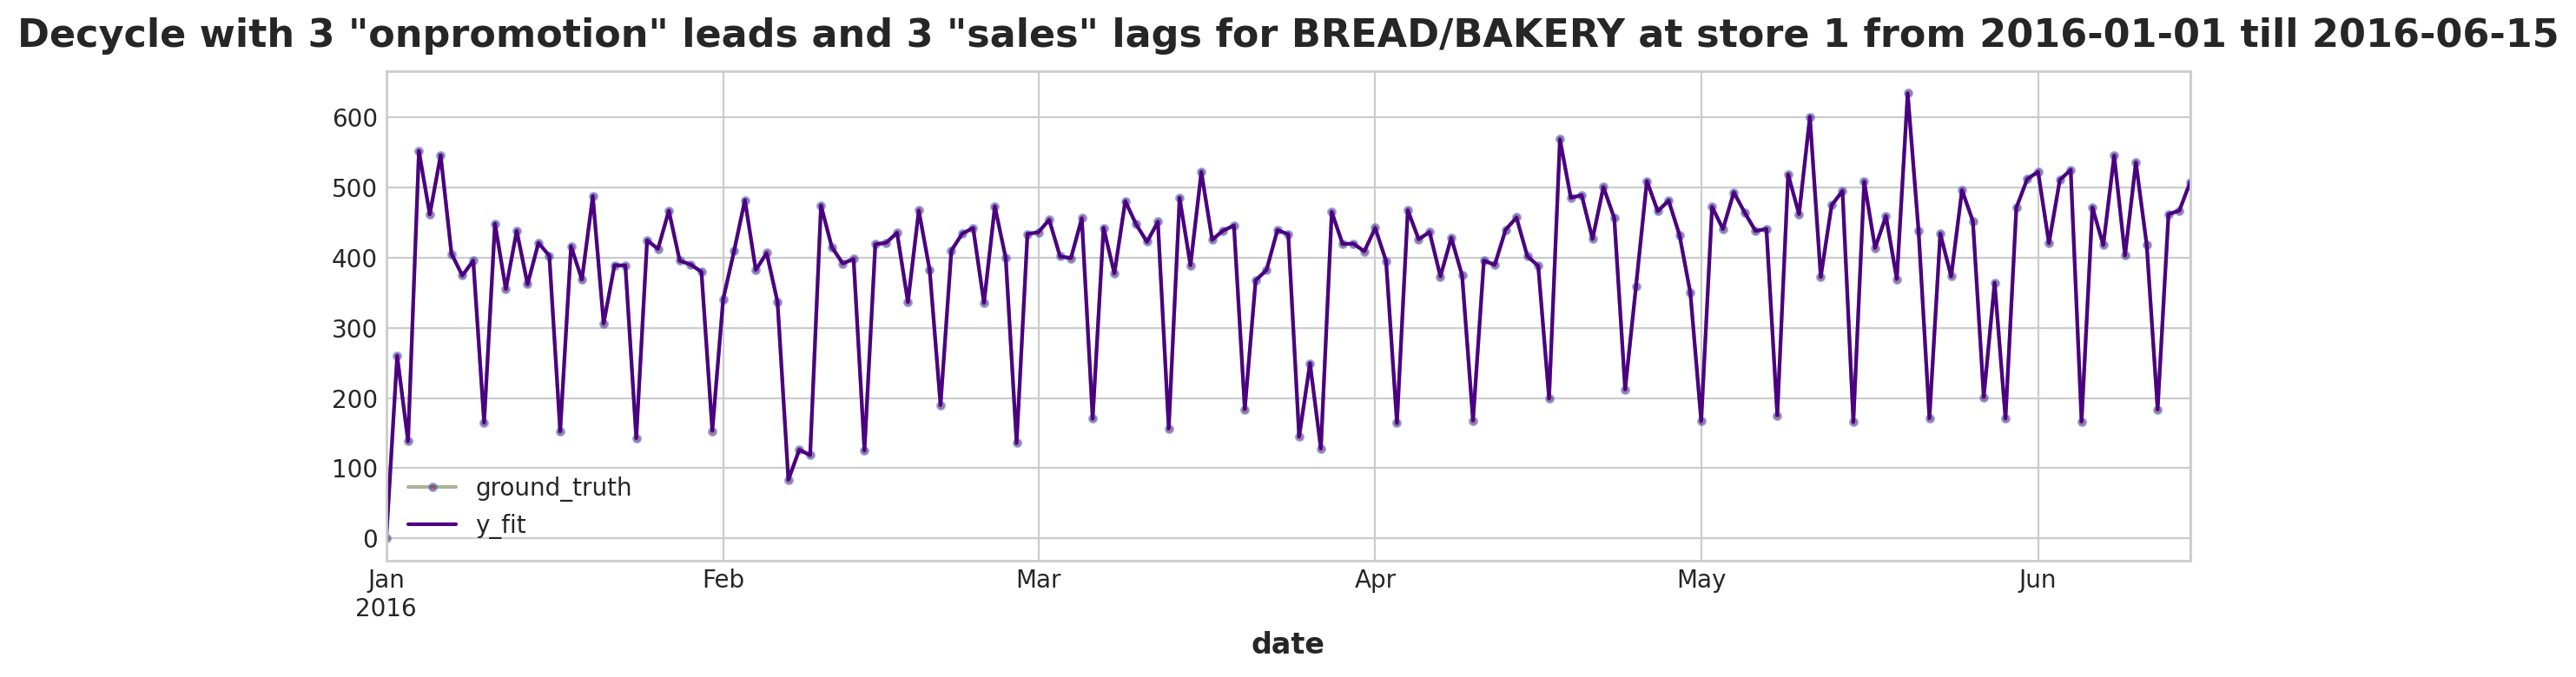

In [83]:
"""
The fit is still perfect. 
XGB must have learned all the noise in the training data.
Some regularization would be just right.
"""

check(X_cycl, 
      y = y_train, 
      STORE = STORE,
      model = XGBRegressor(),
      Prefix = 'Decycle with 3 "onpromotion" leads and 3 "sales" lags')

In [84]:
from sklearn.preprocessing import LabelEncoder

le_family = LabelEncoder()
X_cycl['family_fact'] = X_cycl.index.get_level_values('family')
X_cycl['family_fact'] = le_family.fit_transform(X_cycl['family_fact'])

X_cycl['store_fact'] = X_cycl.index.get_level_values('store_nbr').astype(int)
X_cycl = X_cycl.unstack(['family', 'store_nbr'])

In [85]:
X_cycl_train = X_cycl.loc[:'2017-08-15']
X_cycl_train_micro, y_train_multi_micro = X_cycl_train.align(y_train_multi_micro, join='inner', axis=0)
X_cycl_train_micro = X_cycl_train_micro.stack(['family', 'store_nbr'])

In [86]:
X_cycl_test = X_cycl.loc['2017-08-16':'2017-08-16']
X_cycl_test = X_cycl_test.stack(['family', 'store_nbr'])

In [87]:
# model_MBH.fit(X_vulcano_micro, X_cycl_train_micro, y_train_multi_micro)
# joblib.dump(model_MBH, 'BoostedHybridMultiCycl.pkl')

In [88]:
model_MBH_cycl = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybridMultiCycl.pkl')
y_model_MBH_fit = pd.DataFrame(model_MBH_cycl
                               .predict(X_vulcano_micro, X_cycl_train_micro),
                               index = X_cycl_train_micro.index
                              ).clip(0.0).unstack(['family','store_nbr']) 

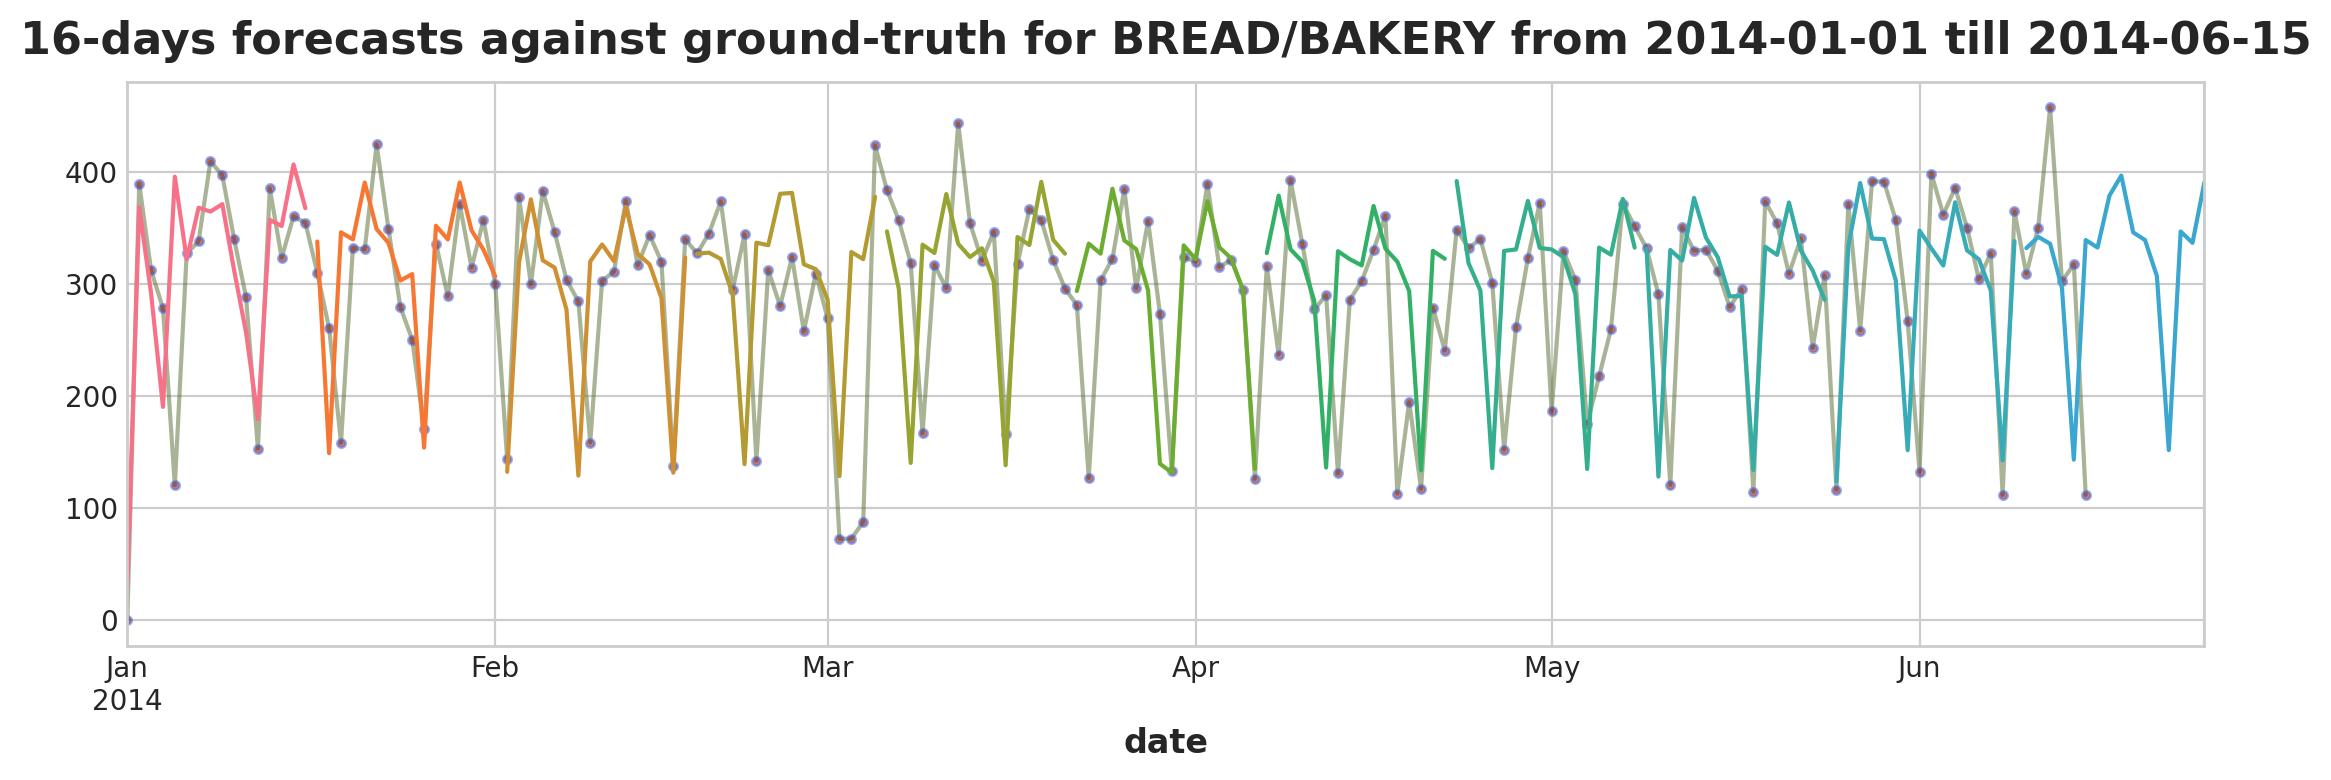

In [89]:
check_multistep (y_model_MBH_fit,
                START = '2014-01-01', 
                END = '2014-06-15')

In [90]:
y_model_MBH_fore = pd.DataFrame(model_MBH_cycl
                               .predict(X_vulcano_test, X_cycl_test),
                               index = X_cycl_test.index
                              ).clip(0.0).unstack(['family','store_nbr'])

In [91]:
submission_8 = (fetch_forecast(y_model_MBH_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_8['sales'] = submission_8.iloc[:,0]
submission_8 = submission_8[['id','sales']]
# submission_8.to_csv('/kaggle/working/submission.csv', index=False)

# SUBMISSION WITH ROLLING STATISTICS
- Public Score (RMSLE): **0.56976**

## Rolling_7_mean
We've learned how to compute moving averages to estimate trends. Computing **rolling statistics** to be used as features is similar except we need to take care *to avoid lookahead leakage*.<br>
**First**, the result should be set at the right end of the window instead of the center - that is, we should use `center=False` (the default) in the rolling method. <br>
**Second**, the target should be lagged a step.

In [92]:
"""
Above text is from the course. 
Now you understand that lagging a step is needed to make X_test for the next day after X_train.
On your Big Forecast Day of '2017-08-16' you will have rolling statistics up to '2017-08-15',
which will allow you to make a forecast.
"""

X_rolling_7_mean = (X_merged
                    .groupby(['family', 'store_nbr'])[['sales']]
                    .shift(1)
                    .fillna(0.0)
                    .rolling (window = 7,
                            center = False,
                            min_periods = 0)
                    .mean()
                    .rename(columns={'sales':'7_days_mean'})
                    )
# X_rolling_7_mean

Mean Squared Log Error: 0.20204


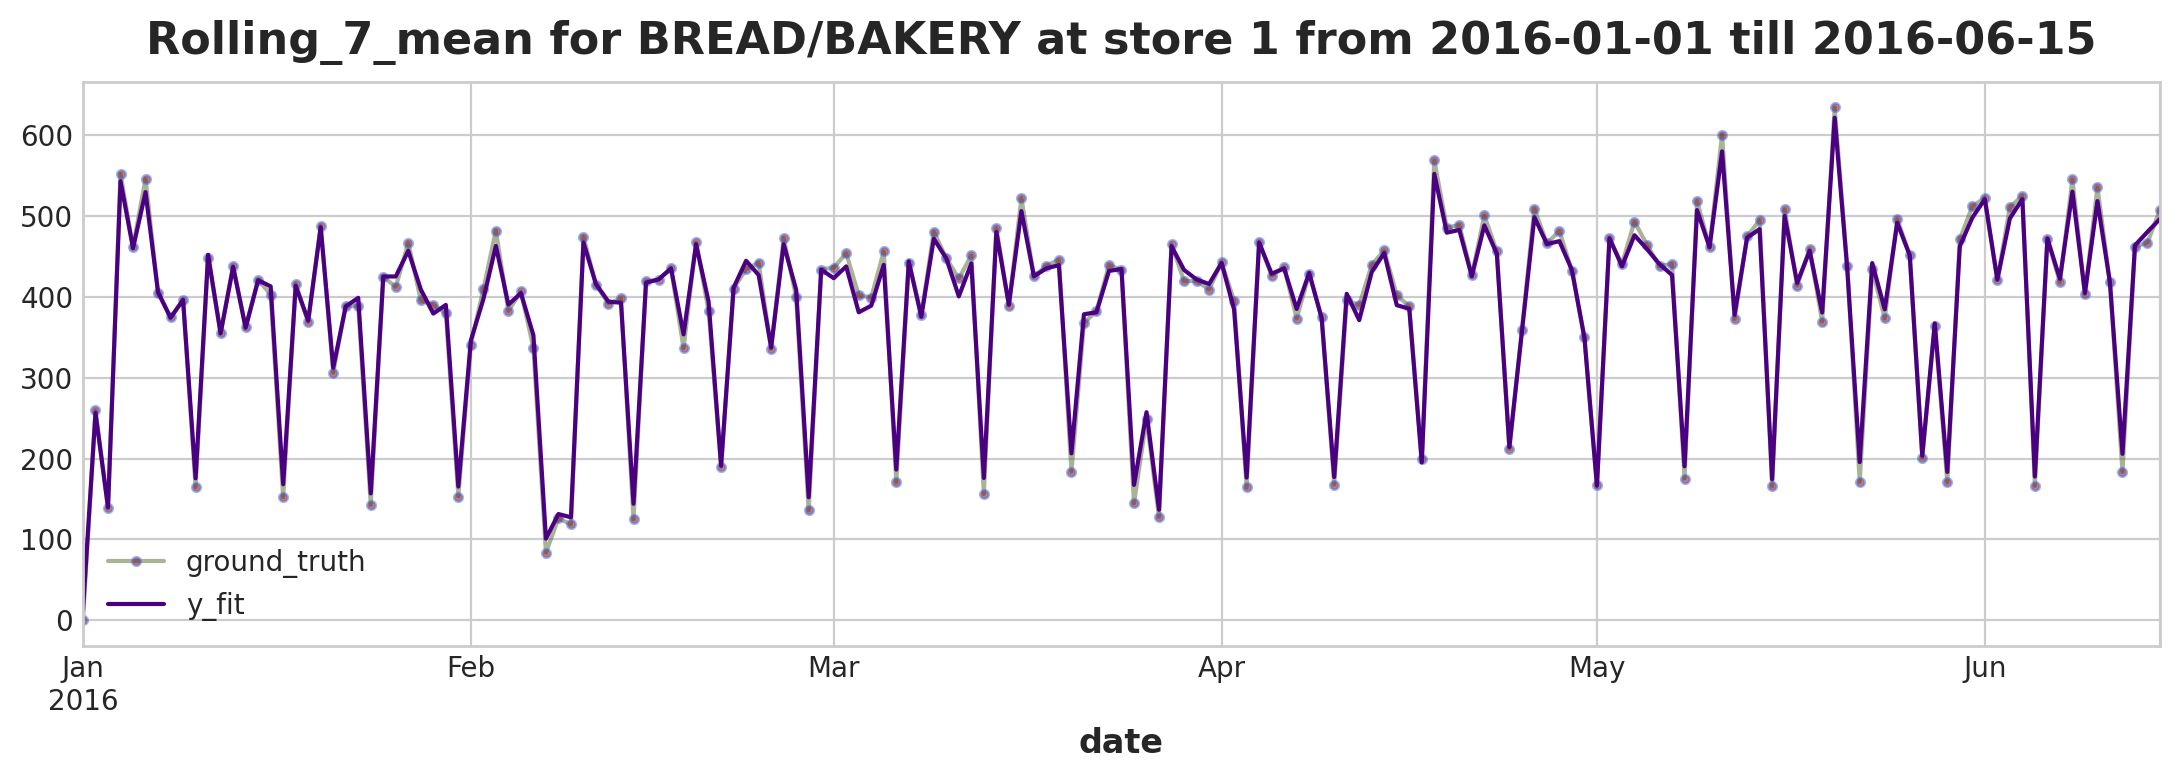

In [93]:
"""
Try the options:
1. 'FIT = False' to see two independent curves
2. 'FIT = True' to see this feature's fit with LinearRegression.
3. 'FIT = True' and uncomment '#model = XGBRegressor()' to see this feature's fit with XGB. 
    
    NB: the perfect XGB fit suggests that
    with a prediction it will be the same: it will perfectly fit to the eroneous 
    forecast produced by another model.
"""
check (X_rolling_7_mean, 
       y = y_train, 
       STORE = STORE, 
       # FIT = False, 
       model = XGBRegressor(),
       Prefix = f'Rolling_7_mean')

## Rolling_7_std

In [94]:
X_rolling_7_std = (X_merged
                    .groupby(['family', 'store_nbr'])[['sales']]
                    .shift(1)
                    .fillna(0.0)
                    .rolling (window = 7,
                             center = False,
                             min_periods = 0)
                    .std()
                    .fillna(0.0)
                    .rename(columns={'sales':'7_days_std'})
                    )

Mean Squared Log Error: 0.20204


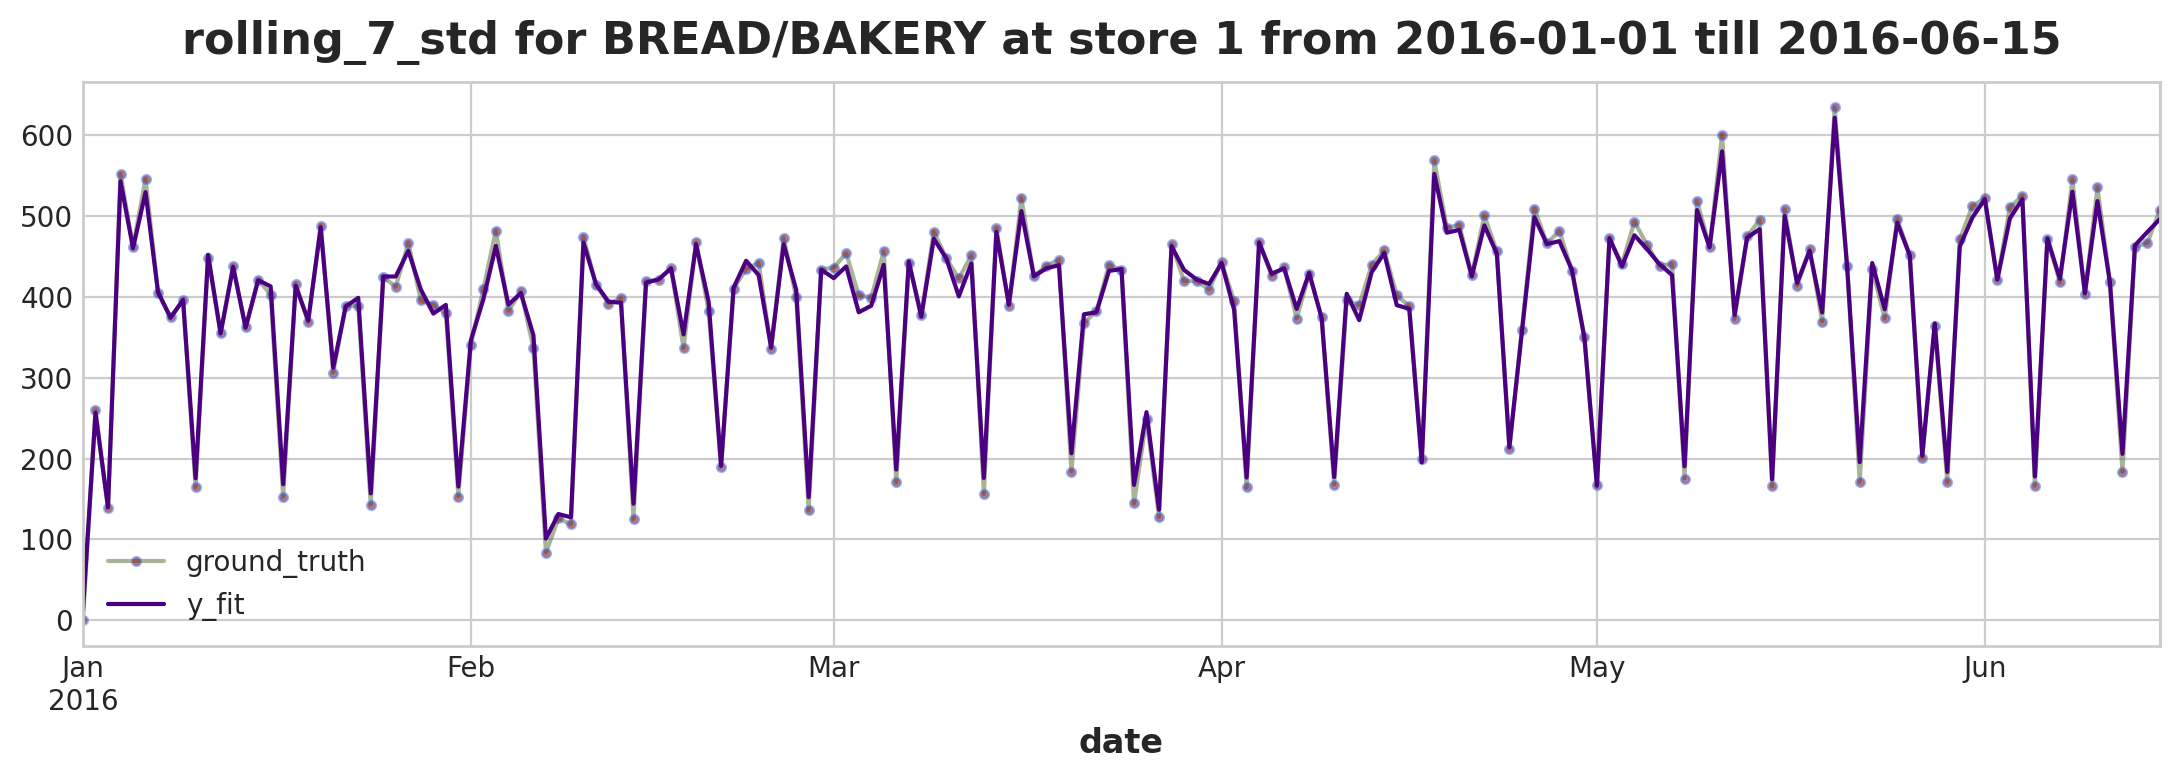

In [95]:
"""
Try the options:
1. 'FIT = False' to see two independent curves
2. 'FIT = True' to see this feature's fit with LinearRegression.
3. 'FIT = True' and uncomment '#model = XGBRegressor()' to see this feature's fit with XGB. 
"""
check (X_rolling_7_std, 
       y = y_train, 
       STORE = STORE, 
       # FIT = False,
       model = XGBRegressor(),
       Prefix = f'rolling_7_std')

## Rolling_5_exp

In [96]:
X_rolling_5_exp = (X_merged
                    .groupby(['family', 'store_nbr'])[['sales']]
                    .shift(1)
                    .fillna(0.0)
                    .ewm (span = 5,
                          adjust= False)
                    .mean()
                    .rename(columns={'sales':'5_days_exp'})
                    )

Mean Squared Log Error: 0.20204


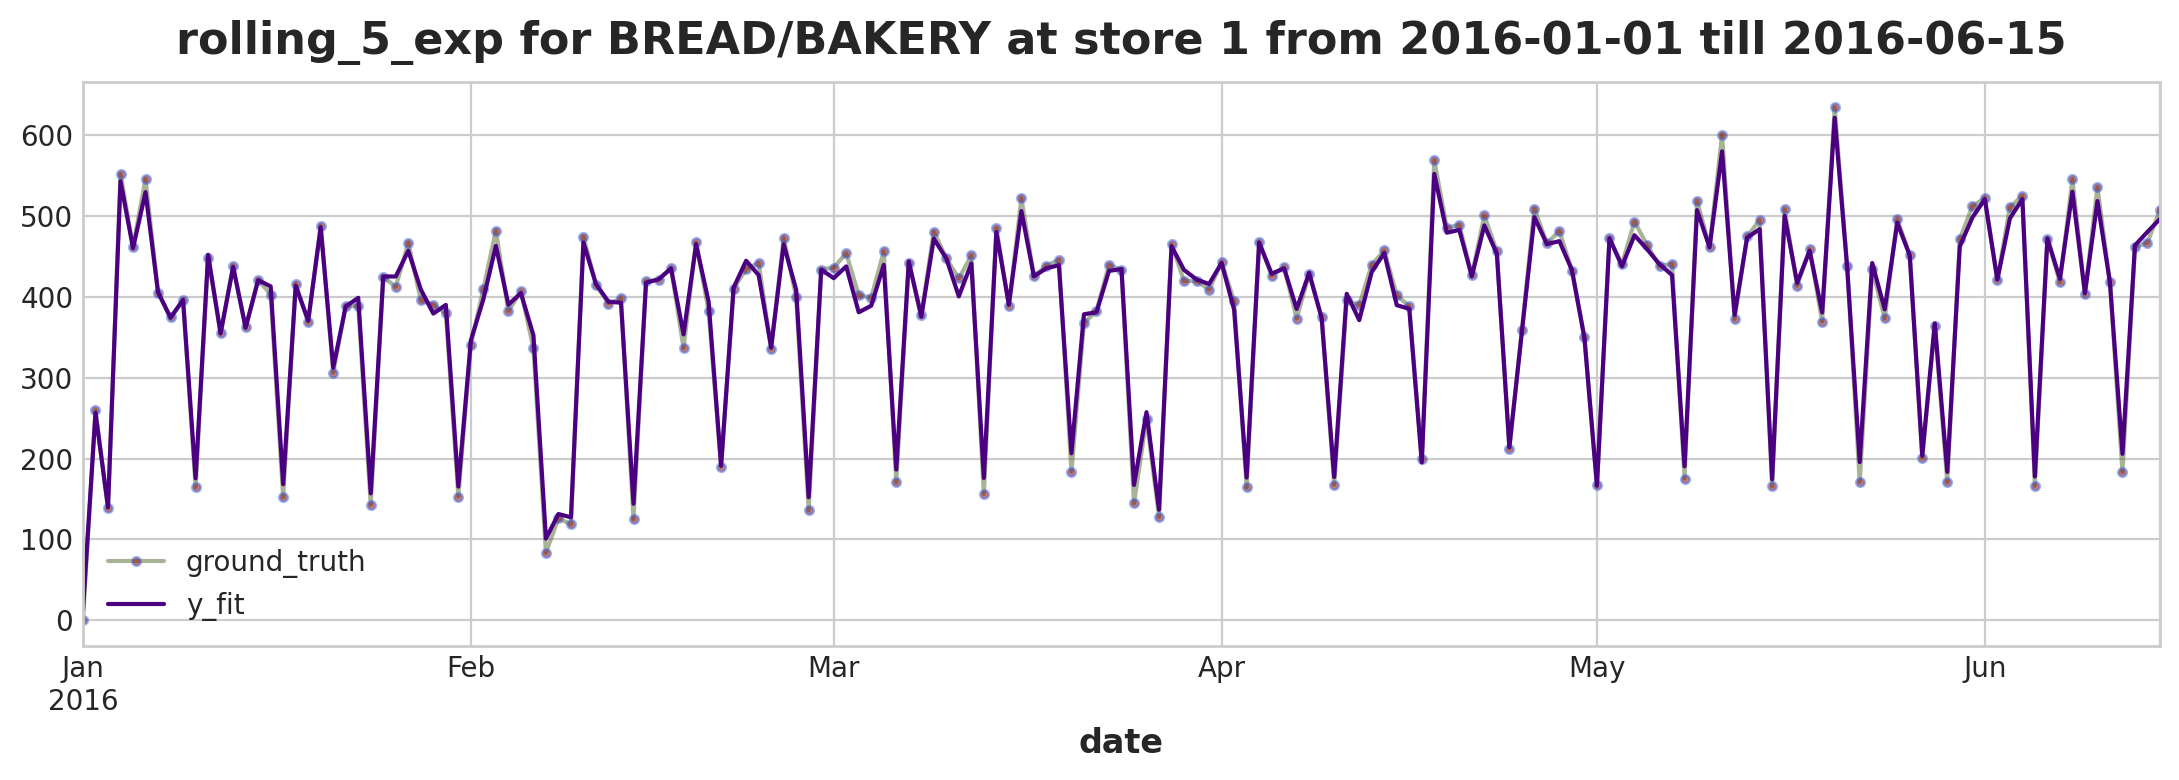

In [97]:
"""
Try the options:
1. 'FIT = False' to see two independent curves
2. 'FIT = True' to see this feature's fit with LinearRegression.
3. 'FIT = True' and uncomment '#model = XGBRegressor()' to see this feature's fit with XGB. 
"""
check (X_rolling_5_exp, 
       y = y_train, 
       STORE = STORE, 
       # FIT = False,
       model = XGBRegressor(),
       Prefix = f'rolling_5_exp')

## Assemble and submit

In [98]:
X_cycl_ = X_cycl.stack(['family', 'store_nbr'])
X_rolling = pd.concat([
                X_cycl_,
                X_rolling_7_mean,
                X_rolling_7_std,
                X_rolling_5_exp
            ],
                axis = 1
)

X_rolling = X_rolling.unstack(['family', 'store_nbr'])

In [99]:
X_rolling_train = X_rolling.loc[:'2017-08-15']
X_rolling_train_micro, y_train_multi_micro = X_rolling_train.align(y_train_multi_micro, join='inner', axis=0)
X_rolling_train_micro = X_rolling_train_micro.stack(['family', 'store_nbr'])

In [100]:
X_rolling_test = X_rolling.loc['2017-08-16':'2017-08-16']
X_rolling_test = X_rolling_test.stack(['family', 'store_nbr'])

In [101]:
# model_MBH.fit(X_vulcano_micro, X_rolling_train_micro, y_train_multi_micro)
# joblib.dump(model_MBH, 'BoostedHybridMultiCyclRoll.pkl')

In [102]:
model_MBH_roll = joblib.load('/kaggle/input/timeseriescourse-models/BoostedHybridMultiCyclRoll.pkl')
y_rolling_fit = pd.DataFrame(model_MBH_roll
                               .predict(X_vulcano_micro, X_rolling_train_micro),
                               index = X_rolling_train_micro.index
                              ).clip(0.0).unstack(['family','store_nbr']) 

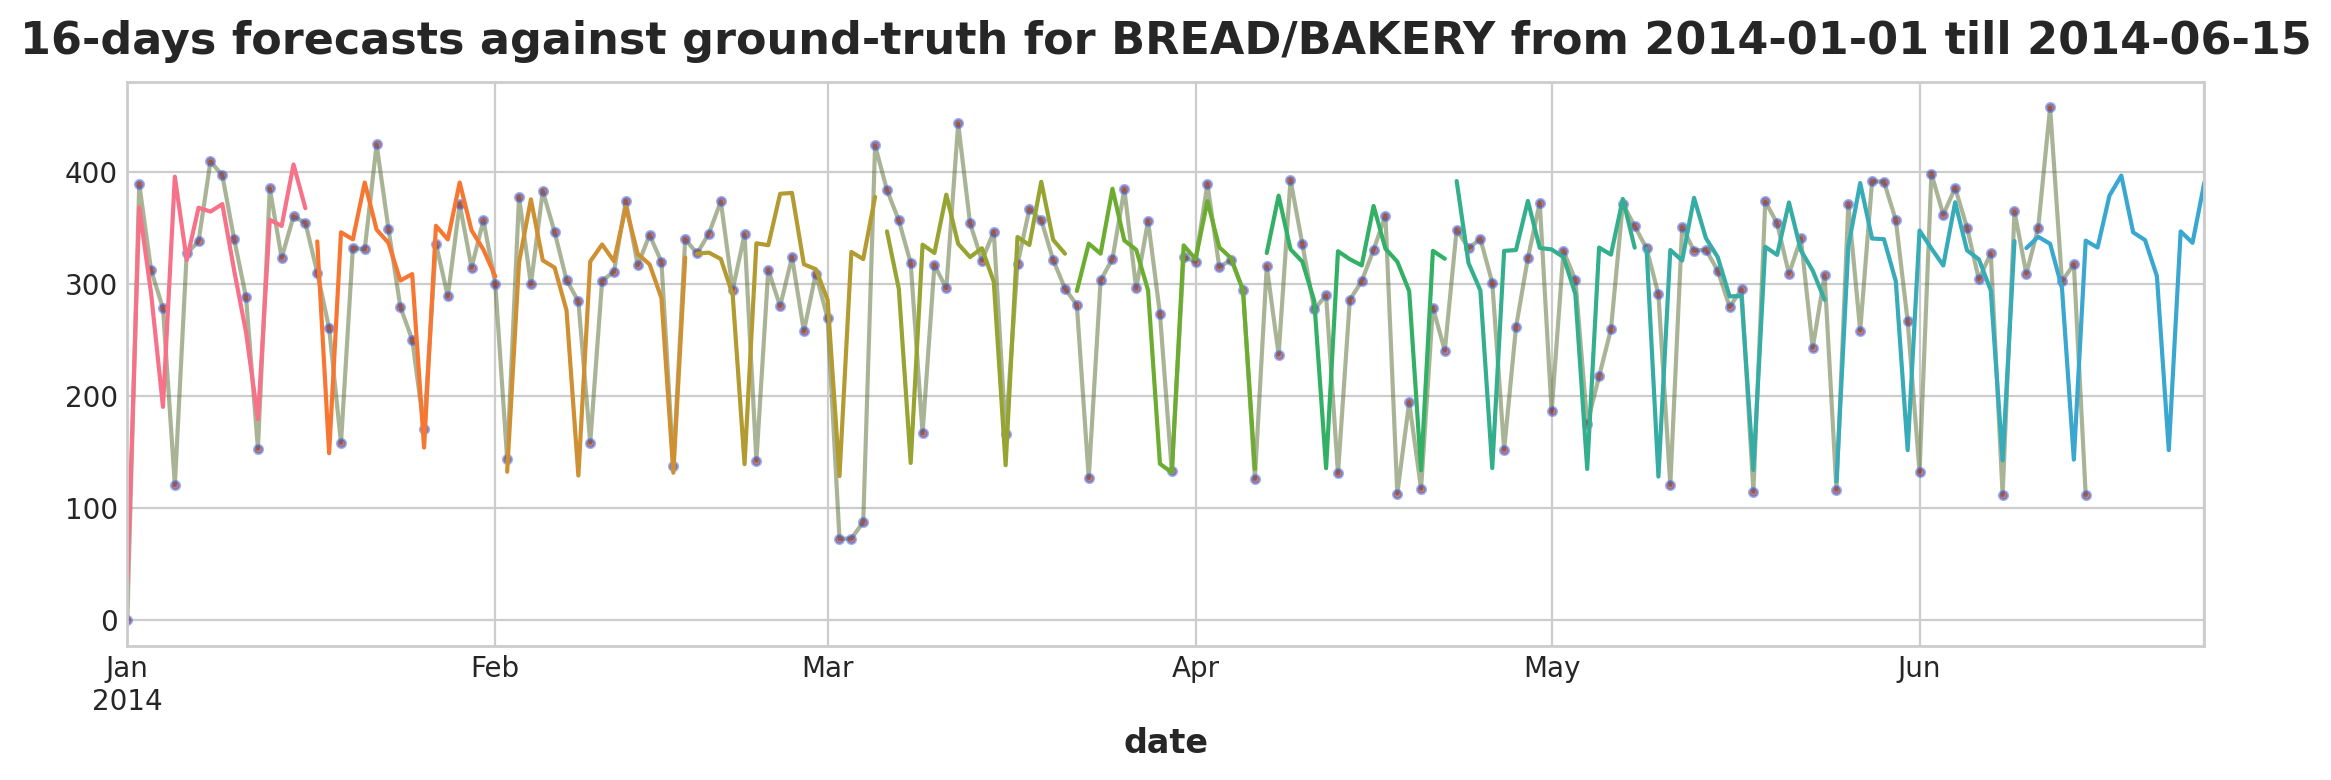

In [103]:
check_multistep (y_rolling_fit,
                START = '2014-01-01', 
                END = '2014-06-15'
                )

In [104]:
y_rolling_fore = pd.DataFrame(model_MBH_roll
                               .predict(X_vulcano_test, X_rolling_test),
                               index = X_cycl_test.index
                              ).clip(0.0).unstack(['family','store_nbr'])

In [105]:
submission_9 = (fetch_forecast(y_rolling_fore)
                  .join(test.id)
                  .reset_index(drop=True)
               )

submission_9['sales'] = submission_9.iloc[:,0]
submission_9 = submission_9[['id','sales']]
# submission_9.to_csv('submission.csv', index=False)

# Bonus: *Simple submission from the course*
Public Score (RMSLE): **0.63832**

In [106]:
X, X_test = dp.in_sample(), dp.out_of_sample(16) 
X['NewYearsDay'] = (X.index.dayofyear == 1) * 1.0
X_test['NewYearsDay'] = (X_test.index.dayofyear == 1) * 1.0

X_2 = X_2.stack(['family','store_nbr'])
X_2 = X_2[['onpromotion','family_fact','store_fact']]
X_2_test = X_2_test[['onpromotion','family_fact','store_fact']]

In [107]:
course_model = BoostedHybrid(
                model_1=LinearRegression(fit_intercept = False),
                model_2=XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
    )

In [108]:
# course_model.fit (X, X_2, y_train)
# joblib.dump(course_model, 'course_model.pkl')

In [109]:
course_model = joblib.load('/kaggle/input/timeseriescourse-models/course_model.pkl')
y_course = course_model.predict(X_test, X_2_test).clip(0.0)

In [110]:
submission_10 = (y_course
            .to_frame()
            .reset_index()
            .rename(columns = {'level_0':'date'})
            .set_index(['date','family', 'store_nbr'])
            .sort_index()    
            .join(test.id)
            .rename(columns = {0:'sales'})
            .reset_index(drop=True)
            .reindex(columns = ['id','sales'])
            )

# submission_10.to_csv('/kaggle/working/submission.csv', index=False)

**Credits**:
- [Rayn Holbrook](https://www.kaggle.com/ryanholbrook) for his brilliant [Time Series course](https://www.kaggle.com/learn/time-series)
- 🐋 whales of the Pacific (feels like a good chance to appreciate them)

If you liked this notebook, please also check the others:
 - [Computer Vision with TPUs](https://www.kaggle.com/code/ivanlydkin/your-default-notebook-for-any-cv-competition-tpus)
 - [Original feature for Titanic](https://www.kaggle.com/code/ivanlydkin/titanic-case-with-some-original-features)


*I hope it was helpful* 🤝<br>
<blockquote style="margin-right:auto; margin-left:auto; background-color: #faf0be; padding: 1em; margin:24px;">
<strong> Please upvote if you find this valuable, and don't hesitate to leave comments if you have any feedback or suggestions</strong> </blockquote><br> 